Análisis de contaminantes en el río Red SAICA (Sistema Automático de Información de Calidad de las Aguas)

-Objetivo-

Analizar la evolución de métricas de calidad del agua medidas por estaciones SAICA, detectar anomalías estadísticas y cruzarlas con el censo de vertidos autorizados asignados a cada estación.

-Fuentes de datos-

Metricas_limpias.csv: series temporales de métricas (pH, turbidez, conductividad, etc.) por estación y timestamp.

reporte_vertidos_asignados.csv: vertidos autorizados asignados a cada estación (tier, volumen, distancia, método).

saica_stations_master_list.json: metadatos de estaciones (nombre, subcuenca, URL).

-Alcance y enfoque-

Enfoque de análisis de datos: control de calidad, estadística descriptiva y detección simple de anomalías (z-score).

El objetivo no es demostrar causalidad, sino priorizar estaciones/zonas para revisión e investigación.


1 - Preparación y carga de datos

1) Importar librerías.
2) Cargar las mediciones (Metricas_limpias.csv).
3) Verificar estructura básica (columnas, tamaño).



In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [54]:
df = pd.read_csv("/content/sample_data/Metricas_limpias.csv")

Interpretación esperada

Deberíamos observar decenas/cientos de miles de filas.

Un conjunto reducido de estaciones (sensor_id) y un número limitado de métricas (metric).


In [55]:
df

,timestamp,value,sensor_id,metric,unit,batch,trans_value,z_score_abs
0,2025-10-02T14:00:00.000000000Z,7.400000,C323,PH,ph,batch1,7.400000,4.440892e-09
1,2025-10-02T14:00:00.000000000Z,0.095310,C322,AMONIO,ppm,batch1,0.095310,1.774644e+00
2,2025-10-02T14:00:00.000000000Z,1.163151,C342,CLOROFILA,µg/l,batch1,1.163151,6.388911e-01
3,2025-10-02T14:00:00.000000000Z,1.064711,C323,CARBONO ORGANICO,ppm,batch1,1.064711,1.691932e+00
4,2025-10-02T14:00:00.000000000Z,2.610070,C313,CLOROFILA,ppb,batch1,2.610070,3.181695e+00
...,...,...,...,...,...,...,...,...
278032,2025-12-19T19:00:00.000000000Z,12.000000,C314,TEMPERATURA,ºC,batch9,12.000000,9.195018e-01
278033,2025-12-19T19:00:00.000000000Z,0.000000,C308,AMONIO,mg/l,batch9,0.000000,0.000000e+00
278034,2025-12-19T19:00:00.000000000Z,8.400000,C329,PH,ph,batch9,8.400000,6.869899e-01
278035,2025-12-19T19:00:00.000000000Z,0.741937,C304,FOSFATOS,ppm,batch9,0.741937,5.747907e-01


2 - Auditoría estructural del dataset

Se valida lo siguiente:

Conversión de timestamp a fecha/hora.

Existencia de nulos por columna.

Duplicados por clave (timestamp, sensor_id, metric, batch).

Distribución de filas por métrica y por batch.

-Interpretación:

Sin nulos y sin duplicados indica limpieza estructural correcta.

Diferencias de conteo entre métricas pueden ser esperables (no todas las estaciones miden todo siempre).


In [56]:
ts = pd.to_datetime(df["timestamp"], errors="coerce")

resumen = pd.DataFrame({
    "campo": [
        "Filas",
        "Sensores (sensor_id) únicos",
        "Métricas (metric) únicas",
        "Batches únicos",
        "Timestamp mínimo",
        "Timestamp máximo",
        "Timestamps inválidos (NaT) tras conversión",
    ],
    "valor": [
        len(df),
        df["sensor_id"].nunique(),
        df["metric"].nunique(),
        df["batch"].nunique() if "batch" in df.columns else "N/A",
        ts.min(),
        ts.max(),
        ts.isna().sum(),
    ]
})

display(resumen)

print("\nNulos por columna (ordenado):")
display(df.isna().sum().sort_values(ascending=False))

clave = [c for c in ["timestamp", "sensor_id", "metric", "batch"] if c in df.columns]
if len(clave) >= 3:
    n_dup = df.duplicated(subset=clave).sum()
    print(f"\nDuplicados exactos según clave {clave}: {n_dup}")
else:
    print("\nNo se puede calcular duplicados por clave estándar (faltan columnas).")

print("\nRecuento de filas por métrica (top 15):")
display(df["metric"].value_counts().head(15))

if "batch" in df.columns:
    print("\nRecuento de filas por batch:")
    display(df["batch"].value_counts())


,campo,valor
0,Filas,278037
1,Sensores (sensor_id) únicos,30
2,Métricas (metric) únicas,12
3,Batches únicos,8
4,Timestamp mínimo,2025-10-02 14:00:00+00:00
5,Timestamp máximo,2026-01-13 19:00:00+00:00
6,Timestamps inválidos (NaT) tras conversión,0



Nulos por columna (ordenado):


,0
timestamp,0
value,0
sensor_id,0
metric,0
unit,0
batch,0
trans_value,0
z_score_abs,0



Duplicados exactos según clave ['timestamp', 'sensor_id', 'metric', 'batch']: 0

Recuento de filas por métrica (top 15):


,count
metric,
TEMPERATURA,38439
PH,37157
OXIGENO DISUELTO,37157
CONDUCTIVIDAD,37157
TURBIDEZ,35876
AMONIO,21781
CARBONO ORGANICO,17937
NIVEL,16655
CLOROFILA,10253



Recuento de filas por batch:


,count
batch,
batch10,52297
batch2,52297
batch1,52140
batch9,52101
batch5,29781
batch3,23219
batch6,12999
batch4,3203


- El dataset contiene 278.037 mediciones, 30 estaciones y 12 métricas, organizado en 8 batches.
- No hay valores nulos ni duplicados en la clave (timestamp, sensor_id, metric, batch), lo que facilita pivotados y agregaciones.
- La cobertura por métrica es desigual (Temperatura/pH/OD/Conductividad tienen muchas más observaciones que Fosfatos/Nitratos).
- Los batches tienen tamaños distintos; batch4 es significativamente más pequeño, por lo que sus conclusiones deben tomarse con cautela.

Conclusión de auditoría estructural:
- El dataset está limpio a nivel estructural: sin nulos y sin duplicados según la clave definida.
- El rango temporal cubre desde 2025-10-02 14:00:00+00:00 hasta 2026-01-13 19:00:00+00:00.


3- Auditoría de calidad de señal (series pegadas / ceros)

Problema:

Un dataset puede estar “limpio” (sin nulos) pero contener señales no informativas:

Series pegadas: siempre el mismo valor (nunique = 1).

Series con exceso de ceros: potencial relleno o fallo de sensor.

Por lo tanto:

Se agrupa por (sensor_id, metric) y se calcula:

nº de muestras, nº de valores distintos, media, desviación, tasa de ceros.
Se identifican:

Series pegadas (nunique <= 1).

Series con muchos ceros (zero_rate alto).


Tabla de calidad (ejemplo, 10 filas):


,sensor_id,metric,n,n_nan,nunique,mean,std,min,max,zero_rate,nan_rate
0,C302,AMONIO,1281,0,21,0.208085,0.166610,0.000000,0.488580,0.198283,0.0
1,C302,CONDUCTIVIDAD,1281,0,479,7.521201,0.105505,7.265430,7.717351,0.000000,0.0
2,C302,NITRATOS,1281,0,1,0.000000,0.000000,0.000000,0.000000,1.000000,0.0
3,C302,OXIGENO DISUELTO,1281,0,356,10.182685,1.272711,7.910000,12.440000,0.000000,0.0
4,C302,PH,1281,0,5,8.150898,0.092961,7.900000,8.300000,0.000000,0.0
5,C302,TEMPERATURA,1281,0,95,11.309992,4.154127,5.800000,19.000000,0.000000,0.0
6,C302,TURBIDEZ,1281,0,293,2.736950,0.608340,1.547563,5.601750,0.000000,0.0
7,C303,CLOROFILA,1281,0,154,2.643144,0.276104,2.001480,3.202746,0.000000,0.0
8,C303,CONDUCTIVIDAD,1281,0,249,6.107296,0.198914,5.666427,6.463029,0.000000,0.0
9,C303,FICOCIANINAS,1281,0,1,0.000000,0.000000,0.000000,0.000000,1.000000,0.0


Series PEGADAS (nunique<=1 y n>=50): 31


,sensor_id,metric,n,n_nan,nunique,mean,std,min,max,zero_rate,nan_rate
74,C313,PH,1282,0,1,0.0,0.0,0.0,0.0,1.0,0.0
195,C342,TURBIDEZ,1282,0,1,0.0,0.0,0.0,0.0,1.0,0.0
210,C345,CLOROFILA,1282,0,1,0.0,0.0,0.0,0.0,1.0,0.0
211,C345,CONDUCTIVIDAD,1282,0,1,0.0,0.0,0.0,0.0,1.0,0.0
212,C345,FICOCIANINAS,1282,0,1,0.0,0.0,0.0,0.0,1.0,0.0
213,C345,OXIGENO DISUELTO,1282,0,1,0.0,0.0,0.0,0.0,1.0,0.0
214,C345,PH,1282,0,1,0.0,0.0,0.0,0.0,1.0,0.0
215,C345,TEMPERATURA,1282,0,1,0.0,0.0,0.0,0.0,1.0,0.0
216,C345,TURBIDEZ,1282,0,1,0.0,0.0,0.0,0.0,1.0,0.0
2,C302,NITRATOS,1281,0,1,0.0,0.0,0.0,0.0,1.0,0.0


Series con MUCHOS ceros (zero_rate>=0.9 y n>=50): 26


,sensor_id,metric,n,n_nan,nunique,mean,std,min,max,zero_rate,nan_rate
74,C313,PH,1282,0,1,0.0,0.0,0.0,0.0,1.0,0.0
195,C342,TURBIDEZ,1282,0,1,0.0,0.0,0.0,0.0,1.0,0.0
210,C345,CLOROFILA,1282,0,1,0.0,0.0,0.0,0.0,1.0,0.0
211,C345,CONDUCTIVIDAD,1282,0,1,0.0,0.0,0.0,0.0,1.0,0.0
212,C345,FICOCIANINAS,1282,0,1,0.0,0.0,0.0,0.0,1.0,0.0
213,C345,OXIGENO DISUELTO,1282,0,1,0.0,0.0,0.0,0.0,1.0,0.0
214,C345,PH,1282,0,1,0.0,0.0,0.0,0.0,1.0,0.0
215,C345,TEMPERATURA,1282,0,1,0.0,0.0,0.0,0.0,1.0,0.0
216,C345,TURBIDEZ,1282,0,1,0.0,0.0,0.0,0.0,1.0,0.0
2,C302,NITRATOS,1281,0,1,0.0,0.0,0.0,0.0,1.0,0.0


Top sensores con más métricas problemáticas:


,sensor_id,flag_stuck,flag_zeros,flag_nan
0,C308,8,8,0
1,C345,7,7,0
2,C320,4,0,0
3,C302,1,1,0
4,C303,1,1,0
5,C304,1,1,0
6,C306,1,1,0
7,C309,1,1,0
8,C310,1,1,0
9,C312,1,1,0



Métricas pegadas en C308


,metric,n,mean,min,max,zero_rate
40,AMONIO,1281,0.0,0.0,0.0,1.0
41,CARBONO ORGANICO,1281,0.0,0.0,0.0,1.0
42,CONDUCTIVIDAD,1281,0.0,0.0,0.0,1.0
43,NIVEL,1281,0.0,0.0,0.0,1.0
44,OXIGENO DISUELTO,1281,0.0,0.0,0.0,1.0
45,PH,1281,0.0,0.0,0.0,1.0
46,TEMPERATURA,1281,0.0,0.0,0.0,1.0
47,TURBIDEZ,1281,0.0,0.0,0.0,1.0



Métricas pegadas en C345


,metric,n,mean,min,max,zero_rate
210,CLOROFILA,1282,0.0,0.0,0.0,1.0
211,CONDUCTIVIDAD,1282,0.0,0.0,0.0,1.0
212,FICOCIANINAS,1282,0.0,0.0,0.0,1.0
213,OXIGENO DISUELTO,1282,0.0,0.0,0.0,1.0
214,PH,1282,0.0,0.0,0.0,1.0
215,TEMPERATURA,1282,0.0,0.0,0.0,1.0
216,TURBIDEZ,1282,0.0,0.0,0.0,1.0



Métricas pegadas en C320


,metric,n,mean,min,max,zero_rate
101,CONDUCTIVIDAD,1281,6.729824,6.729824,6.729824,0.0
102,OXIGENO DISUELTO,1281,10.100000,10.100000,10.100000,0.0
103,PH,1281,7.900000,7.900000,7.900000,0.0
104,TEMPERATURA,1281,15.200000,15.200000,15.200000,0.0


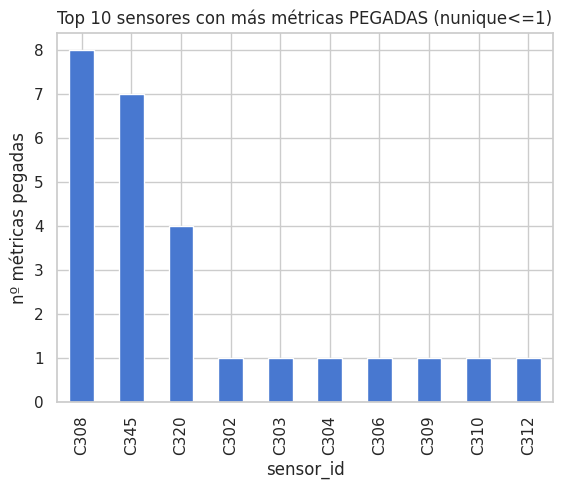

In [57]:
import pandas as pd
import numpy as np

MIN_SAMPLES = 50
ZERO_RATE_TH = 0.90

cols_need = [c for c in ["sensor_id", "metric", "batch", "timestamp", "value"] if c in df.columns]
df_aux = df[cols_need].copy()
df_aux["value_num"] = pd.to_numeric(df_aux["value"], errors="coerce")

quality = (
    df_aux.groupby(["sensor_id", "metric"], dropna=False)
          .agg(
              n=("value_num", "size"),
              n_nan=("value_num", lambda s: s.isna().sum()),
              nunique=("value_num", "nunique"),
              mean=("value_num", "mean"),
              std=("value_num", "std"),
              min=("value_num", "min"),
              max=("value_num", "max"),
              zero_rate=("value_num", lambda s: (s == 0).mean())
          )
          .reset_index()
)

quality["nan_rate"] = quality["n_nan"] / quality["n"]

print("Tabla de calidad (ejemplo, 10 filas):")
display(quality.head(10))

stuck = quality[(quality["n"] >= MIN_SAMPLES) & (quality["nunique"] <= 1)].copy()
stuck = stuck.sort_values(["zero_rate", "n"], ascending=[False, False])

print(f"Series PEGADAS (nunique<=1 y n>={MIN_SAMPLES}): {len(stuck)}")
display(stuck.head(25))

too_many_zeros = quality[(quality["n"] >= MIN_SAMPLES) & (quality["zero_rate"] >= ZERO_RATE_TH)].copy()
too_many_zeros = too_many_zeros.sort_values(["zero_rate", "n"], ascending=[False, False])

print(f"Series con MUCHOS ceros (zero_rate>={ZERO_RATE_TH} y n>={MIN_SAMPLES}): {len(too_many_zeros)}")
display(too_many_zeros.head(25))

sensor_flags = (
    quality.assign(
        flag_stuck=(quality["n"] >= MIN_SAMPLES) & (quality["nunique"] <= 1),
        flag_zeros=(quality["n"] >= MIN_SAMPLES) & (quality["zero_rate"] >= ZERO_RATE_TH),
        flag_nan=(quality["n"] >= MIN_SAMPLES) & (quality["nan_rate"] >= 0.10)  # opcional: >=10% NaN
    )
    .groupby("sensor_id")[["flag_stuck", "flag_zeros", "flag_nan"]]
    .sum()
    .sort_values(["flag_stuck", "flag_zeros", "flag_nan"], ascending=False)
    .reset_index()
)

print("Top sensores con más métricas problemáticas:")
display(sensor_flags.head(15))

top10 = sensor_flags.head(10).set_index("sensor_id")["flag_stuck"]
ax = top10.plot(kind="bar", title="Top 10 sensores con más métricas PEGADAS (nunique<=1)")
ax.set_xlabel("sensor_id")
ax.set_ylabel("nº métricas pegadas")

for s in ["C308", "C345", "C320"]:
    print(f"\nMétricas pegadas en {s}")
    display(stuck[stuck["sensor_id"] == s][["metric", "n", "mean", "min", "max", "zero_rate"]].sort_values("metric"))



- Se detectan 31 combinaciones (sensor_id, metric) con series “pegadas” (nunique = 1 y n >= 50), muchas de ellas con valor 0 constante.
- Se detectan 26 combinaciones con exceso de ceros (zero_rate >= 0.90).
- Las estaciones más afectadas son C308 (8 métricas pegadas) y C345 (7 métricas pegadas). C320 presenta 4 métricas pegadas con valores constantes no nulos.
Implicación: estas señales pueden corresponder a fallo de sensor o relleno de datos; conviene etiquetarlas y tratarlas aparte en el análisis de anomalías para no sacar conclusiones erróneas.

Interpretación

- Si una estación tiene muchas métricas pegadas/ceros, sus resultados pueden ser poco fiables.

- Estas estaciones deben marcarse para:
  1) revisión de sensor,
  2) exclusión del análisis interpretativo,
  3) o imputación (si el pipeline lo contempla).

A tener en cuenta que se detectan series pegadas en múltiples combinaciones (sensor_id, metric).

Destacan estaciones con varias métricas a valor constante (p. ej. valores 0 constantes), lo que sugiere fallo de sensor o relleno.



4- Detección simple de anomalías (z-score)

Anomalías (z_score_abs)

Usamos la columna z_score_abs ya calculada en el dataset como indicador simple de anomalía.
- Definimos un umbral (2.5 en este caso).
- Calculamos anomalías por estación (sensor_id) y por métrica (metric).
- Mostramos rankings y gráficas.

El objetivo es identificar observaciones “atípicas” en las métricas, como señales de posibles episodios anómalos.

Se utiliza z_score_abs (valor absoluto del z-score) calculado previamente.
- Se marca como anomalía si z_score_abs > TH.

A tener en cuenta que este criterio detecta outliers estadísticos, no necesariamente contaminación real. Se debe interpretar junto con calidad de datos y contexto.


In [58]:
import pandas as pd
import numpy as np

TH = 2.5

df_anom = df.copy()

df_anom["z_score_abs"] = pd.to_numeric(df_anom["z_score_abs"], errors="coerce")
df_anom["is_anom"] = df_anom["z_score_abs"] > TH

anom_by_sensor = (
    df_anom.groupby("sensor_id")["is_anom"]
           .agg(n_total="size", n_anom="sum")
           .reset_index()
)
anom_by_sensor["anom_rate"] = anom_by_sensor["n_anom"] / anom_by_sensor["n_total"]
anom_by_sensor = anom_by_sensor.sort_values(["n_anom", "anom_rate"], ascending=False)

print(f"Ranking por estación (umbral z_score_abs > {TH})")
display(anom_by_sensor.head(15))

anom_by_metric = (
    df_anom.groupby("metric")["is_anom"]
           .agg(n_total="size", n_anom="sum")
           .reset_index()
)
anom_by_metric["anom_rate"] = anom_by_metric["n_anom"] / anom_by_metric["n_total"]
anom_by_metric = anom_by_metric.sort_values(["n_anom", "anom_rate"], ascending=False)

print(f"Ranking por métrica (umbral z_score_abs > {TH})")
display(anom_by_metric)


Ranking por estación (umbral z_score_abs > 2.5)


,sensor_id,n_total,n_anom,anom_rate
18,C325,8967,172,0.019181
28,C344,8967,157,0.017509
3,C306,11530,136,0.011795
23,C330,10248,132,0.012881
4,C307,10248,123,0.012002
17,C323,10256,119,0.011603
24,C331,8974,111,0.012369
20,C327,11529,111,0.009628
27,C343,8974,101,0.011255
26,C342,8974,88,0.009806


Ranking por métrica (umbral z_score_abs > 2.5)


,metric,n_total,n_anom,anom_rate
9,PH,37157,391,0.010523
11,TURBIDEZ,35876,350,0.009756
3,CONDUCTIVIDAD,37157,300,0.008074
0,AMONIO,21781,289,0.013268
8,OXIGENO DISUELTO,37157,223,0.006002
1,CARBONO ORGANICO,17937,160,0.008920
10,TEMPERATURA,38439,151,0.003928
7,NIVEL,16655,129,0.007745
2,CLOROFILA,10253,108,0.010534
4,FICOCIANINAS,10253,86,0.008388


-Lectura de resultados
- anom_by_sensor: prioriza estaciones con más anomalías (conteo y tasa).
- anom_by_metric: identifica qué métricas generan más outliers (pH, turbidez, etc.).


5- Visualización de rankings(Gráficas)

Estas gráficas muestran el ranking de anomalías usando todos los datos (sin filtrar series pegadas).



El objetivo:

Representar de forma rápida:
- qué estaciones concentran más anomalías,
- qué métricas concentran más anomalías.

Esto facilita la priorización para investigación.


Text(0, 0.5, 'nº anomalías')

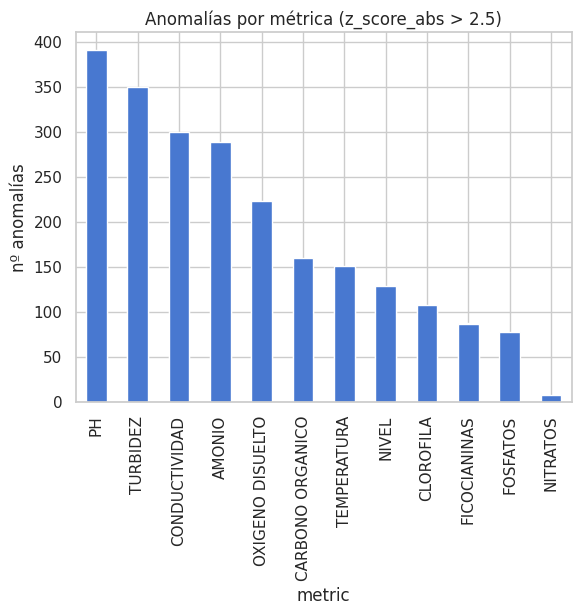

In [59]:
topN = 10

ax1 = anom_by_sensor.head(topN).set_index("sensor_id")["n_anom"].plot(
    kind="bar",
    title=f"Top {topN} estaciones por nº de anomalías (z_score_abs > {TH})"
)
ax1.set_xlabel("sensor_id")
ax1.set_ylabel("nº anomalías")

ax2 = anom_by_metric.set_index("metric")["n_anom"].plot(
    kind="bar",
    title=f"Anomalías por métrica (z_score_abs > {TH})"
)
ax2.set_xlabel("metric")
ax2.set_ylabel("nº anomalías")


6 - Ranking filtrado (excluyendo series pegadas)- Cálculo de rankings (FILTRADO)
Excluimos combinaciones (sensor_id, metric) con series “pegadas” (nunique<=1) para evitar distorsiones por fallos de sensor o relleno con 0.

Motivo:
Las series pegadas (constantes) pueden:
- ocultar anomalías reales,
- o distorsionar rankings.

Se excluyen combinaciones (sensor_id, metric) identificadas como “pegadas” en la auditoría de calidad.
Se recalculan los rankings de anomalías con datos filtrados.


In [60]:
bad_pairs = set(zip(stuck["sensor_id"], stuck["metric"]))

mask_good = ~df_anom.apply(lambda r: (r["sensor_id"], r["metric"]) in bad_pairs, axis=1)
df_anom_f = df_anom[mask_good].copy()

anom_by_sensor_f = (
    df_anom_f.groupby("sensor_id")["is_anom"]
             .agg(n_total="size", n_anom="sum")
             .reset_index()
)
anom_by_sensor_f["anom_rate"] = anom_by_sensor_f["n_anom"] / anom_by_sensor_f["n_total"]
anom_by_sensor_f = anom_by_sensor_f.sort_values(["n_anom", "anom_rate"], ascending=False)

anom_by_metric_f = (
    df_anom_f.groupby("metric")["is_anom"]
             .agg(n_total="size", n_anom="sum")
             .reset_index()
)
anom_by_metric_f["anom_rate"] = anom_by_metric_f["n_anom"] / anom_by_metric_f["n_total"]
anom_by_metric_f = anom_by_metric_f.sort_values(["n_anom", "anom_rate"], ascending=False)

print("Ranking FILTRADO (sin series pegadas)")
display(anom_by_sensor_f.head(15))
display(anom_by_metric_f)


Ranking FILTRADO (sin series pegadas)


,sensor_id,n_total,n_anom,anom_rate
16,C325,8967,172,0.019181
26,C344,8967,157,0.017509
3,C306,10249,136,0.013270
21,C330,10248,132,0.012881
4,C307,10248,123,0.012002
15,C323,10256,119,0.011603
22,C331,8974,111,0.012369
18,C327,10248,111,0.010831
25,C343,8974,101,0.011255
24,C342,7692,88,0.011440


,metric,n_total,n_anom,anom_rate
9,PH,32031,391,0.012207
11,TURBIDEZ,32031,350,0.010927
3,CONDUCTIVIDAD,33313,300,0.009005
0,AMONIO,20500,289,0.014098
8,OXIGENO DISUELTO,33313,223,0.006694
1,CARBONO ORGANICO,16656,160,0.009606
10,TEMPERATURA,34595,151,0.004365
7,NIVEL,11531,129,0.011187
2,CLOROFILA,8971,108,0.012039
4,FICOCIANINAS,7690,86,0.011183


Gráficas (FILTRADO)


Mismas gráficas, pero excluyendo series pegadas para obtener un ranking más fiable.


Text(0, 0.5, 'nº anomalías')

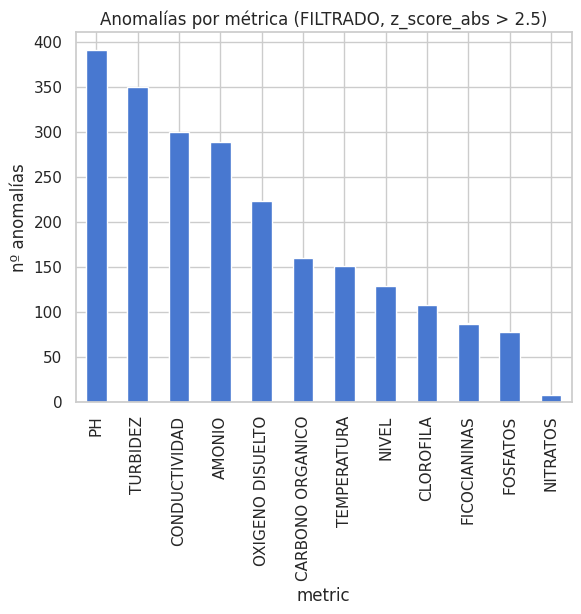

In [61]:
topN = 10

ax1 = anom_by_sensor_f.head(topN).set_index("sensor_id")["n_anom"].plot(
    kind="bar",
    title=f"Top {topN} estaciones por nº de anomalías (FILTRADO, z_score_abs > {TH})"
)
ax1.set_xlabel("sensor_id")
ax1.set_ylabel("nº anomalías")

ax2 = anom_by_metric_f.set_index("metric")["n_anom"].plot(
    kind="bar",
    title=f"Anomalías por métrica (FILTRADO, z_score_abs > {TH})"
)
ax2.set_xlabel("metric")
ax2.set_ylabel("nº anomalías")

-6.1 Exploración manual de casos y validación visual

Objetivo:
Complementar los rankings globales con inspección manual de ejemplos concretos:
- revisar casos extremos (outliers más altos),
- visualizar series temporales específicas por estación/métrica/batch,
- detectar patrones de fallo (saltos, valores atípicos aislados, tramos planos, etc.).

Estas celdas son exploratorias: ayudan a interpretar resultados, pero no cambian el pipeline principal ni sustituyen la auditoría cuantitativa.


In [62]:
top_cases = (
    df_anom[df_anom["is_anom"]]
    .sort_values("z_score_abs", ascending=False)
    [["timestamp", "sensor_id", "metric", "value", "unit", "batch", "z_score_abs"]]
    .head(20)
)

print("Top 20 casos con mayor z_score_abs:")
display(top_cases)


Top 20 casos con mayor z_score_abs:


,timestamp,sensor_id,metric,value,unit,batch,z_score_abs
186441,2025-12-02T05:00:00.000000000Z,C343,FICOCIANINAS,0.095310,µg/l,batch5,9.695897
87486,2026-01-10T13:00:00.000000000Z,C343,PH,7.600000,ph,batch10,9.695897
122573,2025-11-03T05:00:00.000000000Z,C326,AMONIO,0.019803,mg/l,batch2,9.695897
40969,2025-10-10T11:00:00.000000000Z,C327,CONDUCTIVIDAD,0.000000,micrS/cm,batch1,9.695611
166300,2025-11-28T09:00:00.000000000Z,C315,PH,0.000000,ph,batch3,9.694632
25442,2025-10-07T11:00:00.000000000Z,C344,CONDUCTIVIDAD,4.394449,micrS/cm,batch1,9.693876
166414,2025-11-28T09:00:00.000000000Z,C315,CONDUCTIVIDAD,0.000000,micrS/cm,batch3,9.693737
182677,2025-12-01T12:00:00.000000000Z,C314,CONDUCTIVIDAD,2.995732,micrS/cm,batch4,9.686116
161583,2025-11-27T11:00:00.000000000Z,C343,CONDUCTIVIDAD,8.006701,micrS/cm,batch3,9.685767
166355,2025-11-28T09:00:00.000000000Z,C315,CARBONO ORGANICO,0.000000,ppm,batch3,9.669785


In [63]:
df.columns

Index(['timestamp', 'value', 'sensor_id', 'metric', 'unit', 'batch',
       'trans_value', 'z_score_abs'],
      dtype='object')

In [64]:
df.head()

,timestamp,value,sensor_id,metric,unit,batch,trans_value,z_score_abs
0,2025-10-02T14:00:00.000000000Z,7.400000,C323,PH,ph,batch1,7.400000,4.440892e-09
1,2025-10-02T14:00:00.000000000Z,0.095310,C322,AMONIO,ppm,batch1,0.095310,1.774644e+00
2,2025-10-02T14:00:00.000000000Z,1.163151,C342,CLOROFILA,µg/l,batch1,1.163151,6.388911e-01
3,2025-10-02T14:00:00.000000000Z,1.064711,C323,CARBONO ORGANICO,ppm,batch1,1.064711,1.691932e+00
4,2025-10-02T14:00:00.000000000Z,2.610070,C313,CLOROFILA,ppb,batch1,2.610070,3.181695e+00


In [65]:
df_desnormalizado = df.pivot_table(
    index=['timestamp', 'sensor_id', 'batch'], # Las claves que se mantienen fijas
    columns=['metric'],                # Las que se convierten en columnas
    values='value',                            # El dato que quieres ver
    aggfunc='first'                            # Si no hay duplicados, 'first' basta
)

In [66]:
df_desnormalizado.describe()

metric,AMONIO,CARBONO ORGANICO,CLOROFILA,CONDUCTIVIDAD,FICOCIANINAS,FOSFATOS,NITRATOS,NIVEL,OXIGENO DISUELTO,PH,TEMPERATURA,TURBIDEZ
count,21781.000000,17937.000000,10253.000000,37157.000000,10253.000000,7686.000000,7686.000000,16655.000000,37157.000000,37157.000000,38439.000000,35876.000000
mean,0.886934,2.003677,2.054336,5.735650,1.241268,0.394187,1.631896,0.759090,7.185815,6.886506,12.587736,2.111962
std,1.056485,0.852346,1.461553,2.021275,2.338311,0.328127,2.439010,1.005646,3.388065,2.517176,5.953353,1.301202
min,0.000000,0.000000,0.000000,0.000000,-0.223144,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.048790,1.629241,0.832909,5.043425,0.000000,0.000000,0.000000,0.000000,5.090000,7.200000,9.200000,1.098612
50%,0.392042,1.945910,2.116256,6.565265,0.182322,0.512824,0.000000,0.410000,8.240000,7.700000,12.200000,2.302585
75%,1.350667,2.529721,2.965273,7.084612,0.832909,0.672944,3.552702,1.020000,9.900000,8.100000,16.400000,2.890372
max,4.875197,5.295614,5.283711,8.006701,8.597482,2.988708,6.255750,3.730000,13.470000,14.000000,50.000000,8.517393


In [67]:
df

,timestamp,value,sensor_id,metric,unit,batch,trans_value,z_score_abs
0,2025-10-02T14:00:00.000000000Z,7.400000,C323,PH,ph,batch1,7.400000,4.440892e-09
1,2025-10-02T14:00:00.000000000Z,0.095310,C322,AMONIO,ppm,batch1,0.095310,1.774644e+00
2,2025-10-02T14:00:00.000000000Z,1.163151,C342,CLOROFILA,µg/l,batch1,1.163151,6.388911e-01
3,2025-10-02T14:00:00.000000000Z,1.064711,C323,CARBONO ORGANICO,ppm,batch1,1.064711,1.691932e+00
4,2025-10-02T14:00:00.000000000Z,2.610070,C313,CLOROFILA,ppb,batch1,2.610070,3.181695e+00
...,...,...,...,...,...,...,...,...
278032,2025-12-19T19:00:00.000000000Z,12.000000,C314,TEMPERATURA,ºC,batch9,12.000000,9.195018e-01
278033,2025-12-19T19:00:00.000000000Z,0.000000,C308,AMONIO,mg/l,batch9,0.000000,0.000000e+00
278034,2025-12-19T19:00:00.000000000Z,8.400000,C329,PH,ph,batch9,8.400000,6.869899e-01
278035,2025-12-19T19:00:00.000000000Z,0.741937,C304,FOSFATOS,ppm,batch9,0.741937,5.747907e-01


Función auxiliar de visualización
Se define pintar_graficas(df_input) para representar de forma rápida una serie temporal filtrada (por estación, métrica y batch).  
Se usa para inspección visual de comportamientos anómalos (picos, tendencias, valores constantes).


In [68]:
def pintar_graficas(df_input):
    df = df_input.copy()

    if df.empty:
        print("El DataFrame pasado está vacío.")
        return

    df['timestamp'] = pd.to_datetime(df['timestamp'])

    sns.set_theme(style="whitegrid", palette="muted")
    metrics = df['metric'].unique()

    for metric in metrics:
        subset = df[df['metric'] == metric]

        if len(subset) < 10:
            print(f"Métrica '{metric}' ignorada: muy pocos datos ({len(subset)}).")
            continue

        plt.figure(figsize=(10, 6))

        sns.lineplot(data=subset, x="timestamp", y="value", hue="sensor_id", marker='o')

        plt.title(f"Métrica: {metric}")
        plt.xlabel("Fecha")
        plt.ylabel("Valor")
        plt.xticks(rotation=45)

        if metric == 'TEMPERATURA':
            media = subset['value'].mean()

            plt.ylim(media - 2.5, media + 2.5)


        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

In [69]:
df.head()

,timestamp,value,sensor_id,metric,unit,batch,trans_value,z_score_abs
0,2025-10-02T14:00:00.000000000Z,7.400000,C323,PH,ph,batch1,7.400000,4.440892e-09
1,2025-10-02T14:00:00.000000000Z,0.095310,C322,AMONIO,ppm,batch1,0.095310,1.774644e+00
2,2025-10-02T14:00:00.000000000Z,1.163151,C342,CLOROFILA,µg/l,batch1,1.163151,6.388911e-01
3,2025-10-02T14:00:00.000000000Z,1.064711,C323,CARBONO ORGANICO,ppm,batch1,1.064711,1.691932e+00
4,2025-10-02T14:00:00.000000000Z,2.610070,C313,CLOROFILA,ppb,batch1,2.610070,3.181695e+00


In [70]:
df[df['batch'] == 'batch1'].head(5)

,timestamp,value,sensor_id,metric,unit,batch,trans_value,z_score_abs
0,2025-10-02T14:00:00.000000000Z,7.400000,C323,PH,ph,batch1,7.400000,4.440892e-09
1,2025-10-02T14:00:00.000000000Z,0.095310,C322,AMONIO,ppm,batch1,0.095310,1.774644e+00
2,2025-10-02T14:00:00.000000000Z,1.163151,C342,CLOROFILA,µg/l,batch1,1.163151,6.388911e-01
3,2025-10-02T14:00:00.000000000Z,1.064711,C323,CARBONO ORGANICO,ppm,batch1,1.064711,1.691932e+00
4,2025-10-02T14:00:00.000000000Z,2.610070,C313,CLOROFILA,ppb,batch1,2.610070,3.181695e+00


In [71]:
df[df['batch'] == 'batch10'].head(5)

,timestamp,value,sensor_id,metric,unit,batch,trans_value,z_score_abs
52140,2026-01-03T19:00:00.000000000Z,7.800000,C323,PH,ph,batch10,7.800000,0.241269
52141,2026-01-03T19:00:00.000000000Z,0.009950,C322,AMONIO,ppm,batch10,0.009950,0.165458
52142,2026-01-03T19:00:00.000000000Z,4.784989,C342,CLOROFILA,µg/l,batch10,4.784989,0.730204
52143,2026-01-03T19:00:00.000000000Z,5.908083,C303,CONDUCTIVIDAD,micrS/cm,batch10,5.908083,0.769573
52144,2026-01-03T19:00:00.000000000Z,0.262364,C307,AMONIO,mg/l,batch10,0.262364,0.313292


Ejemplos de inspección
A continuación se muestran ejemplos concretos (por batch/estación/métrica) para:
- corroborar si los outliers corresponden a eventos puntuales o a artefactos,
- comparar comportamiento entre batches,
- identificar valores sospechosos que podrían requerir reglas de limpieza adicionales.


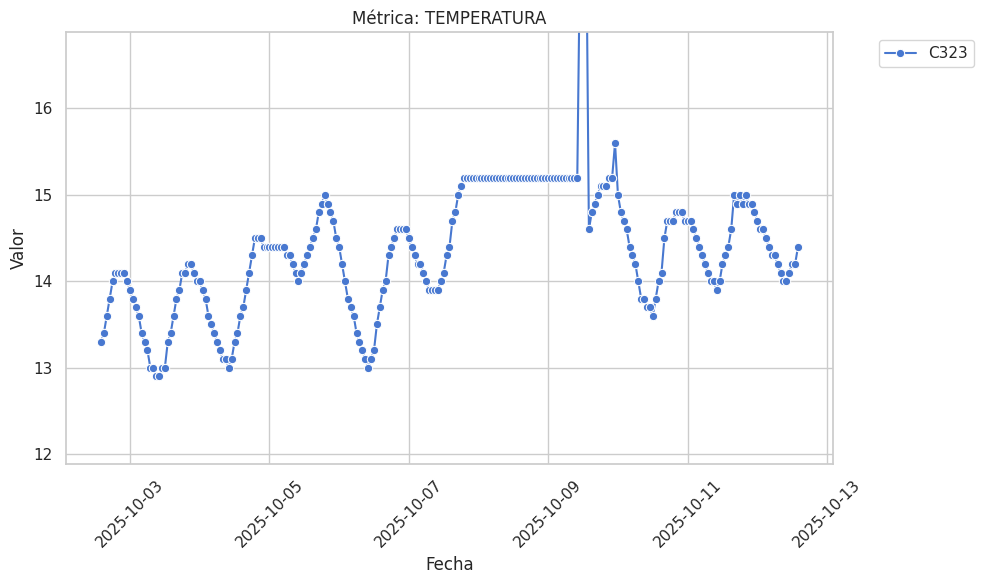


--- Gráficas del Batch 10 ---


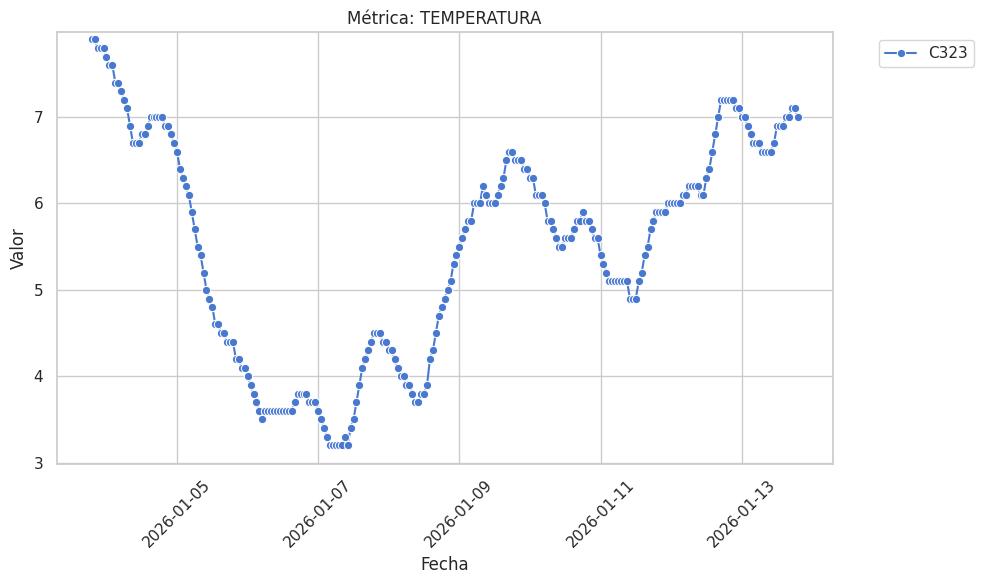

In [72]:
pintar_graficas(df[(df['batch'] == 'batch1') & (df['sensor_id'] == 'C323') & (df['metric'] == 'TEMPERATURA')])

print("\n--- Gráficas del Batch 10 ---")
pintar_graficas(df[(df['batch'] == 'batch10') & (df['sensor_id'] == 'C323') & (df['metric'] == 'TEMPERATURA')])

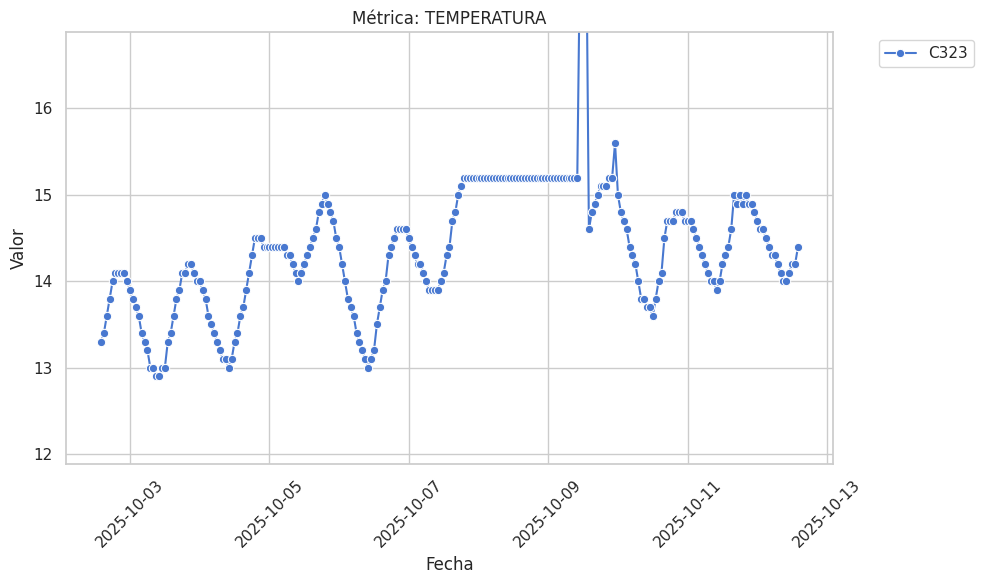


--- Gráficas del Batch 10 ---


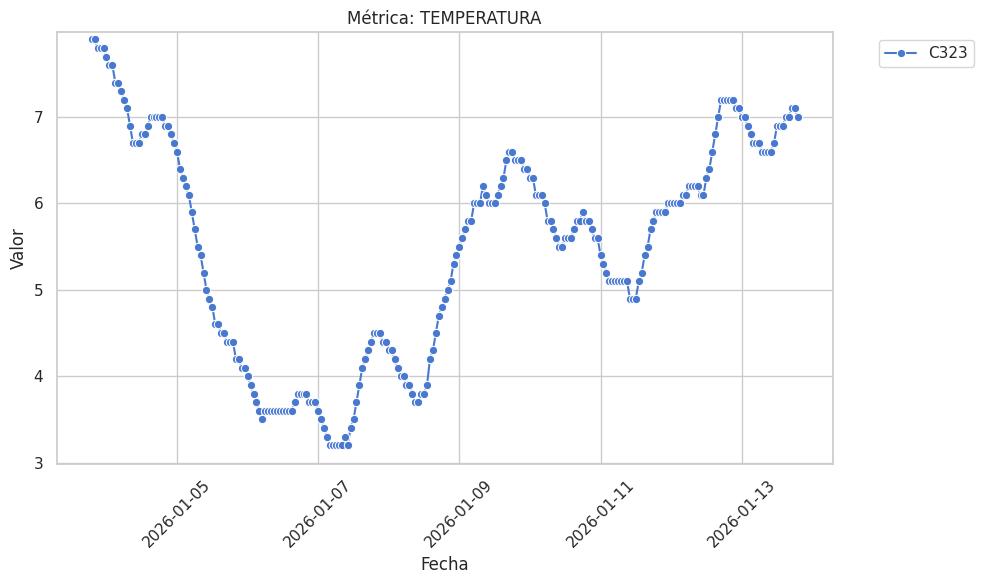

In [73]:
pintar_graficas(df[(df['batch'] == 'batch1') & (df['sensor_id'] == 'C323') & (df['metric'] == 'TEMPERATURA')])

print("\n--- Gráficas del Batch 10 ---")
pintar_graficas(df[(df['batch'] == 'batch10') & (df['sensor_id'] == 'C323') & (df['metric'] == 'TEMPERATURA')])

In [74]:
df[df['batch'] == 'batch1'].describe()

,value,trans_value,z_score_abs
count,52140.000000,52140.000000,52140.000000
mean,5.672511,5.672511,0.596663
std,6.089536,6.089536,0.596396
min,-0.105361,-0.105361,0.000000
25%,0.832909,0.832909,0.132655
50%,3.681477,3.681477,0.477876
75%,7.900000,7.900000,0.886468
max,30.600000,30.600000,9.695611


In [75]:
df.head()

,timestamp,value,sensor_id,metric,unit,batch,trans_value,z_score_abs
0,2025-10-02T14:00:00.000000000Z,7.400000,C323,PH,ph,batch1,7.400000,4.440892e-09
1,2025-10-02T14:00:00.000000000Z,0.095310,C322,AMONIO,ppm,batch1,0.095310,1.774644e+00
2,2025-10-02T14:00:00.000000000Z,1.163151,C342,CLOROFILA,µg/l,batch1,1.163151,6.388911e-01
3,2025-10-02T14:00:00.000000000Z,1.064711,C323,CARBONO ORGANICO,ppm,batch1,1.064711,1.691932e+00
4,2025-10-02T14:00:00.000000000Z,2.610070,C313,CLOROFILA,ppb,batch1,2.610070,3.181695e+00


Identificación de registros sospechosos

En la siguiente celda se muestra un ejemplo de cómo localizar registros candidatos a revisión (por reglas simples).  
No se eliminan datos aquí; cualquier limpieza debe integrarse en el pipeline de limpieza del proyecto.


In [76]:
indices_a_borrar = df[ (df['metric'] == 'TEMPERATURA') & (df['value'] < 19) & (df['sensor_id'] == 'C344') ].index

df = df.drop(indices_a_borrar)

In [77]:
df['sensor_id'].unique()

array(['C323', 'C322', 'C342', 'C313', 'C326', 'C331', 'C317', 'C343',
       'C345', 'C306', 'C303', 'C307', 'C310', 'C330', 'C333', 'C327',
       'C321', 'C325', 'C328', 'C315', 'C316', 'C329', 'C302', 'C344',
       'C314', 'C312', 'C304', 'C309', 'C308', 'C320'], dtype=object)

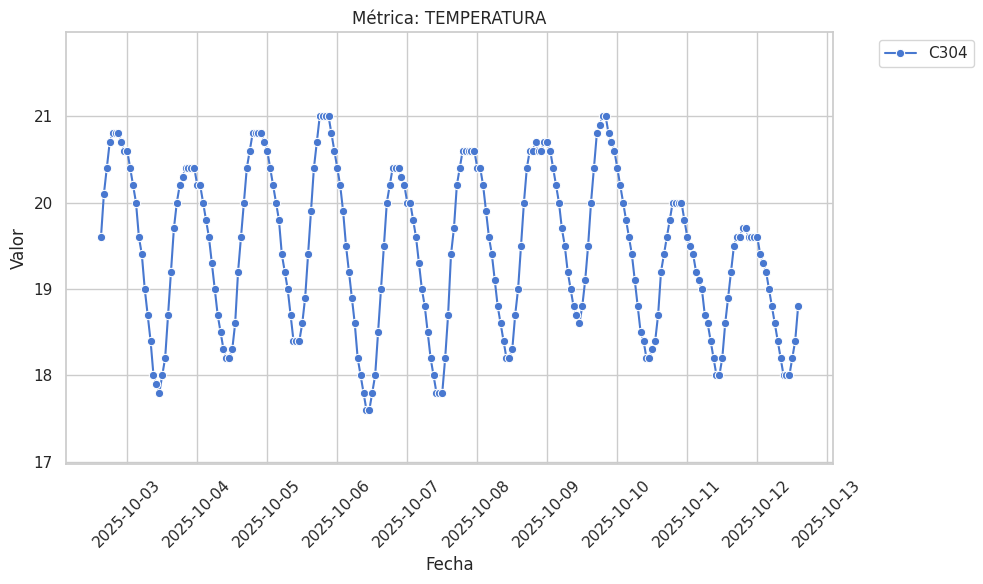

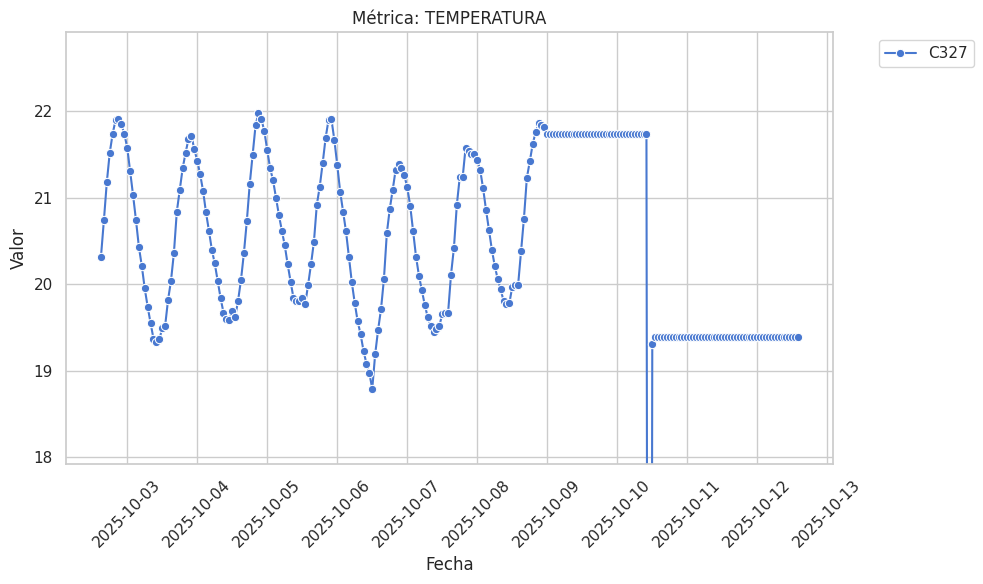

In [78]:
pintar_graficas(df[(df['batch'] == 'batch1') & (df['sensor_id'] == 'C304') & (df['metric'] == 'TEMPERATURA')])
pintar_graficas(df[(df['batch'] == 'batch1') & (df['sensor_id'] == 'C327') & (df['metric'] == 'TEMPERATURA')])

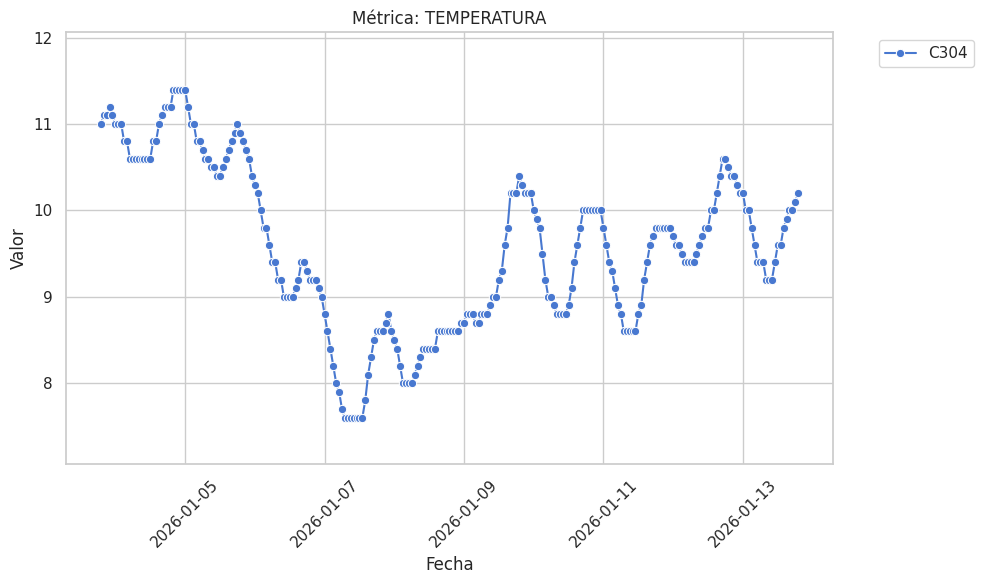

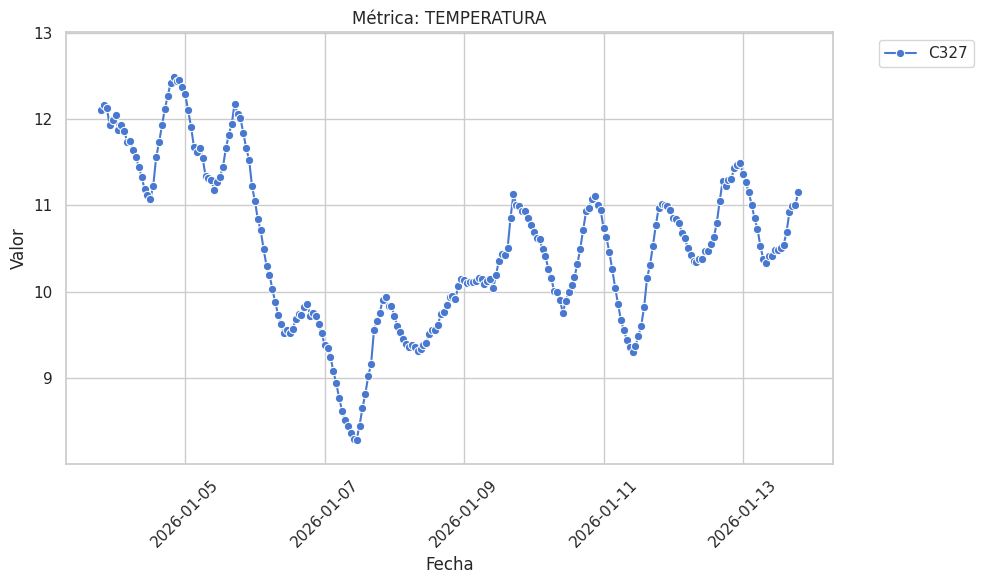

In [79]:
pintar_graficas(df[(df['batch'] == 'batch10') & (df['sensor_id'] == 'C304') & (df['metric'] == 'TEMPERATURA')])
pintar_graficas(df[(df['batch'] == 'batch10') & (df['sensor_id'] == 'C327') & (df['metric'] == 'TEMPERATURA')])

In [80]:
df

,timestamp,value,sensor_id,metric,unit,batch,trans_value,z_score_abs
0,2025-10-02T14:00:00.000000000Z,7.400000,C323,PH,ph,batch1,7.400000,4.440892e-09
1,2025-10-02T14:00:00.000000000Z,0.095310,C322,AMONIO,ppm,batch1,0.095310,1.774644e+00
2,2025-10-02T14:00:00.000000000Z,1.163151,C342,CLOROFILA,µg/l,batch1,1.163151,6.388911e-01
3,2025-10-02T14:00:00.000000000Z,1.064711,C323,CARBONO ORGANICO,ppm,batch1,1.064711,1.691932e+00
4,2025-10-02T14:00:00.000000000Z,2.610070,C313,CLOROFILA,ppb,batch1,2.610070,3.181695e+00
...,...,...,...,...,...,...,...,...
278032,2025-12-19T19:00:00.000000000Z,12.000000,C314,TEMPERATURA,ºC,batch9,12.000000,9.195018e-01
278033,2025-12-19T19:00:00.000000000Z,0.000000,C308,AMONIO,mg/l,batch9,0.000000,0.000000e+00
278034,2025-12-19T19:00:00.000000000Z,8.400000,C329,PH,ph,batch9,8.400000,6.869899e-01
278035,2025-12-19T19:00:00.000000000Z,0.741937,C304,FOSFATOS,ppm,batch9,0.741937,5.747907e-01


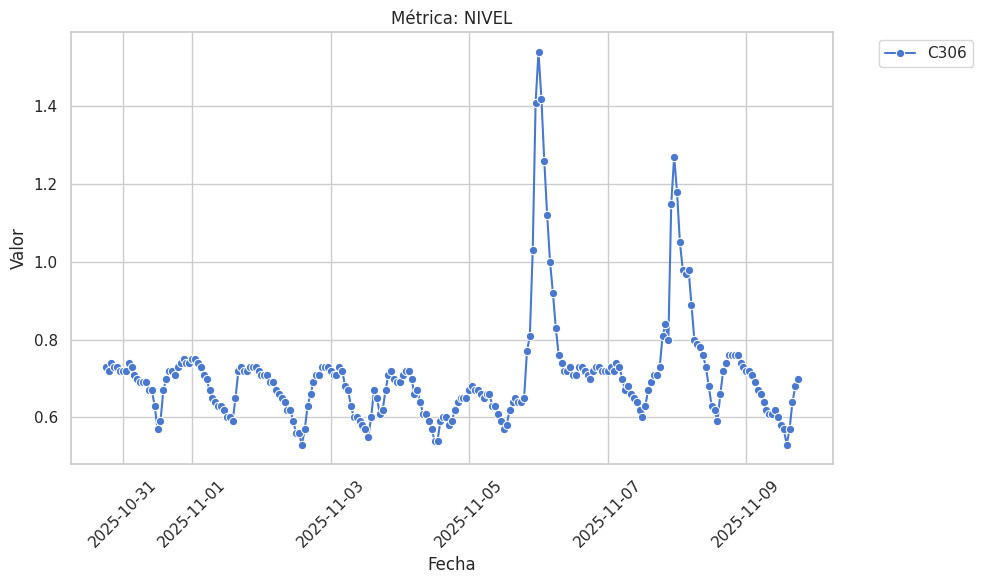

In [81]:
pintar_graficas(df[(df['metric']=='NIVEL') & (df['sensor_id']=='C306') & (df['batch']=='batch2')])

In [82]:
df[(df['metric']=='NIVEL') & (df['sensor_id']=='C306') & (df['batch']=='batch2')]

,timestamp,value,sensor_id,metric,unit,batch,trans_value,z_score_abs
104452,2025-10-30T18:00:00.000000000Z,0.73,C306,NIVEL,m,batch2,0.73,1.234228
104669,2025-10-30T19:00:00.000000000Z,0.72,C306,NIVEL,m,batch2,0.72,1.050826
104886,2025-10-30T20:00:00.000000000Z,0.74,C306,NIVEL,m,batch2,0.74,1.350418
105103,2025-10-30T21:00:00.000000000Z,0.73,C306,NIVEL,m,batch2,0.73,1.165348
105320,2025-10-30T22:00:00.000000000Z,0.73,C306,NIVEL,m,batch2,0.73,1.141212
...,...,...,...,...,...,...,...,...
155664,2025-11-09T14:00:00.000000000Z,0.53,C306,NIVEL,m,batch2,0.53,1.299525
155881,2025-11-09T15:00:00.000000000Z,0.57,C306,NIVEL,m,batch2,0.57,0.988604
156098,2025-11-09T16:00:00.000000000Z,0.64,C306,NIVEL,m,batch2,0.64,0.444347
156315,2025-11-09T17:00:00.000000000Z,0.68,C306,NIVEL,m,batch2,0.68,0.130856


In [83]:
df[(df['metric']=='NIVEL') & (df['sensor_id']=='C306') & (df['batch']=='batch2')].sort_values(by='value', ascending=False)

,timestamp,value,sensor_id,metric,unit,batch,trans_value,z_score_abs
137002,2025-11-06T00:00:00.000000000Z,1.54,C306,NIVEL,m,batch2,1.54,4.341318
137219,2025-11-06T01:00:00.000000000Z,1.42,C306,NIVEL,m,batch2,1.42,3.564778
136785,2025-11-05T23:00:00.000000000Z,1.41,C306,NIVEL,m,batch2,1.41,3.850533
147201,2025-11-07T23:00:00.000000000Z,1.27,C306,NIVEL,m,batch2,1.27,2.654315
137436,2025-11-06T02:00:00.000000000Z,1.26,C306,NIVEL,m,batch2,1.26,2.675441
...,...,...,...,...,...,...,...,...
124199,2025-11-03T13:00:00.000000000Z,0.55,C306,NIVEL,m,batch2,0.55,1.822112
129407,2025-11-04T13:00:00.000000000Z,0.54,C306,NIVEL,m,batch2,0.54,0.912536
129190,2025-11-04T12:00:00.000000000Z,0.54,C306,NIVEL,m,batch2,0.54,0.900731
119208,2025-11-02T14:00:00.000000000Z,0.53,C306,NIVEL,m,batch2,0.53,2.314971


In [84]:
tmp = df[(df['sensor_id']=='C306') & (df['batch']=='batch2')].copy()
tmp['timestamp'] = pd.to_datetime(tmp['timestamp'], errors="coerce")


# 2. Define la lista de días que quieres (en formato string 'YYYY-MM-DD')
dias_deseados = ['2025-11-05', '2025-11-06', '2025-11-07', '2025-11-08']

# 3. Filtra usando .dt.date y .isin()
# Convertimos los strings a objetos date para que la comparación sea exacta
import datetime
dias_objetos = [pd.to_datetime(d).date() for d in dias_deseados]

tmp[tmp['timestamp'].dt.date.isin(dias_objetos)]

,timestamp,value,sensor_id,metric,unit,batch,trans_value,z_score_abs
131791,2025-11-05 00:00:00+00:00,20.020000,C306,TEMPERATURA,ºC,batch2,20.020000,0.399246
131794,2025-11-05 00:00:00+00:00,0.670000,C306,NIVEL,m,batch2,0.670000,0.220533
131796,2025-11-05 00:00:00+00:00,2.480731,C306,TURBIDEZ,NTU,batch2,2.480731,0.728645
131808,2025-11-05 00:00:00+00:00,3.970000,C306,OXIGENO DISUELTO,ppm,batch2,3.970000,0.541821
131876,2025-11-05 00:00:00+00:00,6.905723,C306,CONDUCTIVIDAD,micrS/cm,batch2,6.905723,0.513636
...,...,...,...,...,...,...,...,...
152491,2025-11-08 23:00:00+00:00,6.779513,C306,CONDUCTIVIDAD,micrS/cm,batch2,6.779513,0.137220
152528,2025-11-08 23:00:00+00:00,2.388763,C306,CARBONO ORGANICO,ppm,batch2,2.388763,0.117611
152534,2025-11-08 23:00:00+00:00,0.000000,C306,FOSFATOS,ppm,batch2,0.000000,0.000000
152600,2025-11-08 23:00:00+00:00,7.280000,C306,PH,ph,batch2,7.280000,0.327610


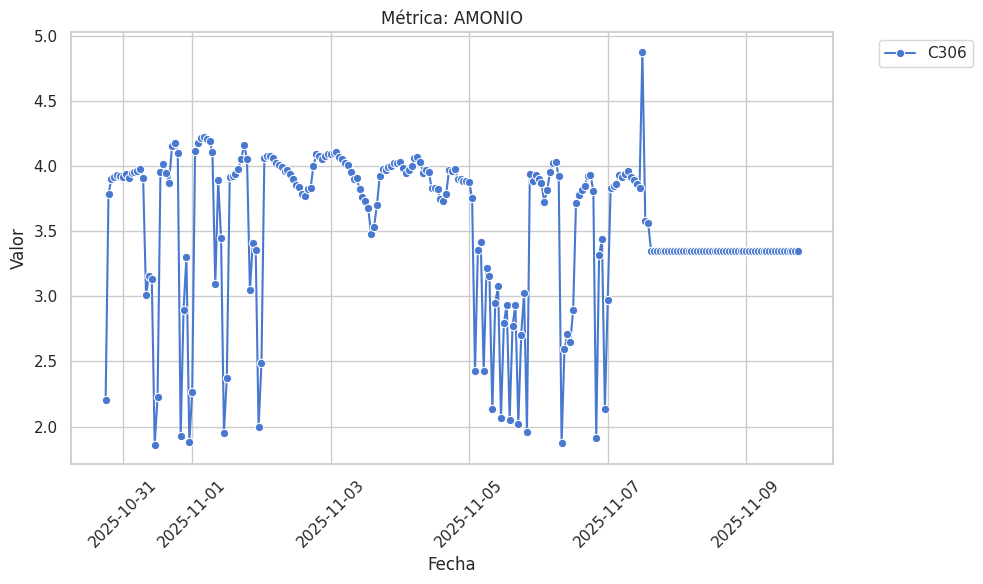

In [85]:
pintar_graficas(tmp[tmp['metric'] == 'AMONIO'])

In [86]:
print(df[(df['sensor_id']=='C306') & (df['batch']=='batch2') & (df['metric']=='AMONIO')]['value'].median())
print(df[(df['sensor_id']=='C306') & (df['batch']=='batch2') & (df['metric']=='AMONIO')]['value'].std())

print(df[(df['sensor_id']=='C330') & (df['batch']=='batch2') & (df['metric']=='AMONIO')]['value'].median())
print(df[(df['sensor_id']=='C330') & (df['batch']=='batch2') & (df['metric']=='AMONIO')]['value'].std())

print(df[(df['sensor_id']=='C333') & (df['batch']=='batch2') & (df['metric']=='AMONIO')]['value'].median())
print(df[(df['sensor_id']=='C333') & (df['batch']=='batch2') & (df['metric']=='AMONIO')]['value'].std())

3.815732345
0.5702799796437841
0.0
0.1286571711181555
0.0
0.027270096625600985


In [87]:
print("HALLAZGOS CLAVE")
print(f"- Series pegadas detectadas: {len(stuck)}")
print("Top sensores con más métricas pegadas:", list(sensor_flags.head(5)["sensor_id"]))

total_anom = int(df_anom["is_anom"].sum())
print(f"- Anomalías totales (GLOBAL, z>{TH}): {total_anom} ({total_anom/len(df_anom):.2%})")

if "df_anom_f" in globals():
    total_anom_f = int(df_anom_f["is_anom"].sum())
    print(f"- Anomalías totales (FILTRADO, z>{TH}): {total_anom_f} ({total_anom_f/len(df_anom_f):.2%})")
    print("  Top estaciones (FILTRADO):", list(anom_by_sensor_f.head(5)["sensor_id"]))

print("- Top estaciones (GLOBAL):", list(anom_by_sensor.head(5)["sensor_id"]))
print("- Top métricas (GLOBAL):", list(anom_by_metric.head(5)["metric"]))


HALLAZGOS CLAVE
- Series pegadas detectadas: 31
Top sensores con más métricas pegadas: ['C308', 'C345', 'C320', 'C302', 'C303']
- Anomalías totales (GLOBAL, z>2.5): 2272 (0.82%)
- Anomalías totales (FILTRADO, z>2.5): 2272 (0.95%)
  Top estaciones (FILTRADO): ['C325', 'C344', 'C306', 'C330', 'C307']
- Top estaciones (GLOBAL): ['C325', 'C344', 'C306', 'C330', 'C307']
- Top métricas (GLOBAL): ['PH', 'TURBIDEZ', 'CONDUCTIVIDAD', 'AMONIO', 'OXIGENO DISUELTO']


- El dataset está limpio a nivel estructural: sin nulos y sin duplicados en (timestamp, sensor_id, metric, batch).
- Se detectan series “pegadas” (nunique=1) en 31 combinaciones (sensor_id, metric), destacando C308 y C345 con múltiples métricas a 0 constante.
- Esto sugiere fallo de sensor o relleno con 0, por lo que estas señales deben etiquetarse o excluirse de análisis interpretativos.
- Con umbral z_score_abs > 2.5, las estaciones con más anomalías (global) son: C325 (172 anomalías), C344 (153), C306 (136), C330 (132), C307 (123) .
- Las métricas con más anomalías son: PH (391 anomalías), TURBIDEZ (350), CONDUCTIVIDAD (300), AMONIO (289), OXIGENO DISUELTO (223), destacando pH, turbidez y conductividad.
- Al filtrar series pegadas, el ranking permanece estable en el Top 5 (misma priorización principal), lo que refuerza la robustez de la conclusión.



7 - Cruce con vertidos autorizados (contexto)

Objetivo:

Cruzar anomalías observadas en sensores con el contexto del censo de vertidos autorizados:
- número de vertidos cercanos,
- categoría estratégica (TIER),
- distancia al sensor,
- volumen (si aplica).


Se permite pasar de “hay anomalías” a “hay anomalías en estaciones con alta presión potencial de vertidos”.
Esto no demuestra causalidad, pero mejora la priorización.


In [88]:
import pandas as pd
import numpy as np

vert = pd.read_csv("/content/sample_data/reporte_vertidos_asignados.csv", sep=";")

for c in ["DISTANCIA_M", "v_volumen", "v_percentil_volumen"]:
    if c in vert.columns:
        vert[c] = pd.to_numeric(vert[c], errors="coerce")

print("Filas:", len(vert))
print("Estaciones (s_id) únicas:", vert["s_id"].nunique())
display(vert["v_categoria_estrategica"].value_counts())
display(vert["METODO_ASIGNACION"].value_counts())


Filas: 1835
Estaciones (s_id) únicas: 30


,count
v_categoria_estrategica,
TIER_3_MENOR,1468
TIER_2_RELEVANTE,274
TIER_1_CRITICO,93


,count
METODO_ASIGNACION,
ESTIMACION_ESPACIAL,1698
CONEXION_HIDROLOGICA,137


In [89]:
vert_sum = (
    vert.groupby("s_id")
        .agg(
            n_vertidos=("v_id","count"),
            total_vol=("v_volumen","sum"),
            mean_vol=("v_volumen","mean"),
            n_tier1=("v_categoria_estrategica", lambda x: (x=="TIER_1_CRITICO").sum()),
            n_tier2=("v_categoria_estrategica", lambda x: (x=="TIER_2_RELEVANTE").sum()),
            n_tier3=("v_categoria_estrategica", lambda x: (x=="TIER_3_MENOR").sum()),
            dist_min=("DISTANCIA_M","min"),
            dist_mean=("DISTANCIA_M","mean"),
        )
        .reset_index()
        .rename(columns={"s_id":"sensor_id"})
)

vert_sum["risk_score"] = (100*vert_sum["n_tier1"] + 10*vert_sum["n_tier2"] + 1*vert_sum["n_tier3"]) / (1 + vert_sum["dist_min"]/10000)

display(vert_sum.sort_values("risk_score", ascending=False).head(15))


,sensor_id,n_vertidos,total_vol,mean_vol,n_tier1,n_tier2,n_tier3,dist_min,dist_mean,risk_score
1,C303,113,5.844292e+07,5.171940e+05,12,17,84,94.921020,16121.812378,1440.328257
23,C330,188,3.540255e+07,1.883114e+05,7,27,154,713.179501,22563.157673,1049.174990
5,C308,89,4.426652e+07,4.973767e+05,7,9,73,340.907612,12117.115355,834.549570
21,C328,19,1.354651e+08,7.129741e+06,8,3,8,174.908548,6504.688436,823.594626
4,C307,78,2.931899e+07,3.758845e+05,6,15,57,121.082616,20093.169285,797.345532
11,C315,49,2.350905e+07,4.797765e+05,6,14,29,785.861311,18245.748132,712.970414
2,C304,43,2.520637e+07,5.861946e+05,5,7,31,634.340603,8803.951660,565.150226
8,C312,57,1.040161e+08,1.824844e+06,3,16,38,183.371208,14820.146274,489.032551
26,C342,89,1.023394e+07,1.149881e+05,3,15,71,795.322576,15668.797751,482.616426
20,C327,26,2.239415e+08,8.613134e+06,5,0,21,1149.330675,9611.330026,467.292625


Interpretación del risk_score
- risk_score es un indicador heurístico: mayor si hay más vertidos críticos y más cercanos.
- Se utiliza solo para priorización, no como medida física de impacto.


8 - Panel integrado: anomalías + vertidos + calidad + metadatos

Se construye una tabla por estación con:
- anomalías (n_anom, anom_rate),
- presión de vertidos (risk_score, n_vertidos, n_tier1, dist_min),
- calidad (flag_stuck, flag_zeros),
- metadatos (nombre, subcuenca, URL).

Es el artefacto principal del informe: permite ver rápidamente dónde priorizar y si el sensor es confiable.


In [90]:
panel_global = anom_by_sensor.merge(vert_sum, on="sensor_id", how="left")
display(panel_global.sort_values("n_anom", ascending=False).head(15))
display(panel_global.sort_values("risk_score", ascending=False).head(15))


,sensor_id,n_total,n_anom,anom_rate,n_vertidos,total_vol,mean_vol,n_tier1,n_tier2,n_tier3,dist_min,dist_mean,risk_score
0,C325,8967,172,0.019181,10,7.077775e+05,7.077775e+04,0,1,9,260.756591,15892.152524,18.517153
1,C344,8967,157,0.017509,52,1.462941e+05,2.813348e+03,0,0,52,3.000000,28839.267113,51.984405
2,C306,11530,136,0.011795,29,2.094546e+07,7.222572e+05,3,2,24,1429.224199,8890.772058,300.982809
3,C330,10248,132,0.012881,188,3.540255e+07,1.883114e+05,7,27,154,713.179501,22563.157673,1049.174990
4,C307,10248,123,0.012002,78,2.931899e+07,3.758845e+05,6,15,57,121.082616,20093.169285,797.345532
5,C323,10256,119,0.011603,122,6.125650e+06,5.021024e+04,1,8,113,211.206061,26305.797481,286.939660
6,C331,8974,111,0.012369,13,1.555408e+06,1.196467e+05,0,3,10,377.524834,36272.396395,38.544837
7,C327,11529,111,0.009628,26,2.239415e+08,8.613134e+06,5,0,21,1149.330675,9611.330026,467.292625
8,C343,8974,101,0.011255,37,5.776104e+06,1.561109e+05,2,7,28,22.803509,25578.580275,297.322002
9,C342,8974,88,0.009806,89,1.023394e+07,1.149881e+05,3,15,71,795.322576,15668.797751,482.616426


,sensor_id,n_total,n_anom,anom_rate,n_vertidos,total_vol,mean_vol,n_tier1,n_tier2,n_tier3,dist_min,dist_mean,risk_score
23,C303,8967,42,0.004684,113,5.844292e+07,5.171940e+05,12,17,84,94.921020,16121.812378,1440.328257
3,C330,10248,132,0.012881,188,3.540255e+07,1.883114e+05,7,27,154,713.179501,22563.157673,1049.174990
27,C308,10248,0,0.000000,89,4.426652e+07,4.973767e+05,7,9,73,340.907612,12117.115355,834.549570
14,C328,11529,76,0.006592,19,1.354651e+08,7.129741e+06,8,3,8,174.908548,6504.688436,823.594626
4,C307,10248,123,0.012002,78,2.931899e+07,3.758845e+05,6,15,57,121.082616,20093.169285,797.345532
17,C315,12810,69,0.005386,49,2.350905e+07,4.797765e+05,6,14,29,785.861311,18245.748132,712.970414
13,C304,11529,82,0.007112,43,2.520637e+07,5.861946e+05,5,7,31,634.340603,8803.951660,565.150226
22,C312,8967,51,0.005688,57,1.040161e+08,1.824844e+06,3,16,38,183.371208,14820.146274,489.032551
9,C342,8974,88,0.009806,89,1.023394e+07,1.149881e+05,3,15,71,795.322576,15668.797751,482.616426
7,C327,11529,111,0.009628,26,2.239415e+08,8.613134e+06,5,0,21,1149.330675,9611.330026,467.292625


In [91]:
if "anom_by_sensor_f" in globals():
    panel_f = anom_by_sensor_f.merge(vert_sum, on="sensor_id", how="left")
    display(panel_f.sort_values("n_anom", ascending=False).head(15))

,sensor_id,n_total,n_anom,anom_rate,n_vertidos,total_vol,mean_vol,n_tier1,n_tier2,n_tier3,dist_min,dist_mean,risk_score
0,C325,8967,172,0.019181,10,7.077775e+05,7.077775e+04,0,1,9,260.756591,15892.152524,18.517153
1,C344,8967,157,0.017509,52,1.462941e+05,2.813348e+03,0,0,52,3.000000,28839.267113,51.984405
2,C306,10249,136,0.013270,29,2.094546e+07,7.222572e+05,3,2,24,1429.224199,8890.772058,300.982809
3,C330,10248,132,0.012881,188,3.540255e+07,1.883114e+05,7,27,154,713.179501,22563.157673,1049.174990
4,C307,10248,123,0.012002,78,2.931899e+07,3.758845e+05,6,15,57,121.082616,20093.169285,797.345532
5,C323,10256,119,0.011603,122,6.125650e+06,5.021024e+04,1,8,113,211.206061,26305.797481,286.939660
6,C331,8974,111,0.012369,13,1.555408e+06,1.196467e+05,0,3,10,377.524834,36272.396395,38.544837
7,C327,10248,111,0.010831,26,2.239415e+08,8.613134e+06,5,0,21,1149.330675,9611.330026,467.292625
8,C343,8974,101,0.011255,37,5.776104e+06,1.561109e+05,2,7,28,22.803509,25578.580275,297.322002
9,C342,7692,88,0.011440,89,1.023394e+07,1.149881e+05,3,15,71,795.322576,15668.797751,482.616426


Text(0, 0.5, 'anom_rate (z_score_abs > TH)')

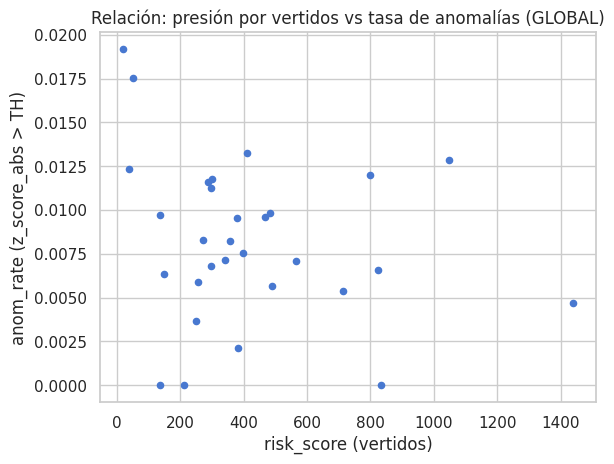

In [92]:
ax = panel_global.plot(
    x="risk_score", y="anom_rate", kind="scatter",
    title="Relación: presión por vertidos vs tasa de anomalías (GLOBAL)"
)
ax.set_xlabel("risk_score (vertidos)")
ax.set_ylabel("anom_rate (z_score_abs > TH)")

Text(0, 0.5, 'risk_score')

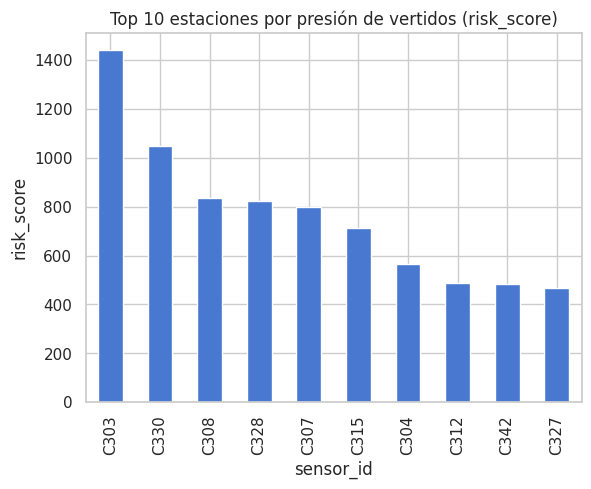

In [93]:
topN = 10
ax = panel_global.sort_values("risk_score", ascending=False).head(topN).set_index("sensor_id")["risk_score"].plot(
    kind="bar", title=f"Top {topN} estaciones por presión de vertidos (risk_score)"
)
ax.set_xlabel("sensor_id")
ax.set_ylabel("risk_score")

Cómo leer la tabla
- Alto risk_score + alta anom_rate → candidato claro a investigación (posible presión + señal).
- Alto risk_score + baja anom_rate → revisar si hay:
  - métricas pegadas,
  - baja sensibilidad,
  - o ausencia de efecto detectable.
- Flags altos (flag_stuck, flag_zeros) → riesgo de conclusiones engañosas por mala calidad de sensor.


In [94]:
panel_q = panel_global.merge(sensor_flags, on="sensor_id", how="left").fillna(0)
display(
    panel_q.sort_values("risk_score", ascending=False)
           .head(15)[["sensor_id","risk_score","n_vertidos","n_tier1","dist_min","n_anom","anom_rate","flag_stuck","flag_zeros"]]
)

,sensor_id,risk_score,n_vertidos,n_tier1,dist_min,n_anom,anom_rate,flag_stuck,flag_zeros
23,C303,1440.328257,113,12,94.921020,42,0.004684,1,1
3,C330,1049.174990,188,7,713.179501,132,0.012881,0,0
27,C308,834.549570,89,7,340.907612,0,0.000000,8,8
14,C328,823.594626,19,8,174.908548,76,0.006592,1,1
4,C307,797.345532,78,6,121.082616,123,0.012002,0,0
17,C315,712.970414,49,6,785.861311,69,0.005386,0,0
13,C304,565.150226,43,5,634.340603,82,0.007112,1,1
22,C312,489.032551,57,3,183.371208,51,0.005688,1,1
9,C342,482.616426,89,3,795.322576,88,0.009806,1,1
7,C327,467.292625,26,5,1149.330675,111,0.009628,1,1


Enriquecimiento con metadatos de estaciones (SAICA master list)

En esta sección se añaden nombre, subcuenca y URL de detalle a los rankings y paneles calculados.

In [95]:
import json
import pandas as pd
from pathlib import Path

ST_PATH = Path("/content/sample_data/saica_stations_master_list.json")

stations = json.loads(ST_PATH.read_text(encoding="utf-8"))
st = pd.DataFrame(stations).rename(columns={"codigo": "sensor_id"})

display(st.head())
print("Estaciones en JSON:", len(st))
print("Columnas:", list(st.columns))


,sensor_id,nombre,subcuenca,url_detalles
0,C322,SAICA CARCABOSO,ALAGÓN,https://saihtajo.chtajo.es/index.php?w=get-est...
1,C323,SAICA BEJAR,ALAGÓN,https://saihtajo.chtajo.es/index.php?w=get-est...
2,C313,SAICA CAZALEGAS,ALBERCHE,https://saihtajo.chtajo.es/index.php?w=get-est...
3,C326,SAICA ESCALONA,ALBERCHE,https://saihtajo.chtajo.es/index.php?w=get-est...
4,C342,SAICA PICADAS,ALBERCHE,https://saihtajo.chtajo.es/index.php?w=get-est...


Estaciones en JSON: 30
Columnas: ['sensor_id', 'nombre', 'subcuenca', 'url_detalles']


In [96]:
anom_by_sensor_named = anom_by_sensor.merge(
    st[["sensor_id", "nombre", "subcuenca", "url_detalles"]],
    on="sensor_id", how="left"
)

display(anom_by_sensor_named.head(15))



,sensor_id,n_total,n_anom,anom_rate,nombre,subcuenca,url_detalles
0,C325,8967,172,0.019181,SAICA MONFRAGÜE,TIÉTAR,https://saihtajo.chtajo.es/index.php?w=get-est...
1,C344,8967,157,0.017509,SAICA AZUTAN,TAJO IZQUIERDA,https://saihtajo.chtajo.es/index.php?w=get-est...
2,C306,11530,136,0.011795,SAICA RIVAS,MADRID,https://saihtajo.chtajo.es/index.php?w=get-est...
3,C330,10248,132,0.012881,SAICA ALGETE,MADRID,https://saihtajo.chtajo.es/index.php?w=get-est...
4,C307,10248,123,0.012002,SAICA SANTOS DE LA HUMOSA,HENARES,https://saihtajo.chtajo.es/index.php?w=get-est...
5,C323,10256,119,0.011603,SAICA BEJAR,ALAGÓN,https://saihtajo.chtajo.es/index.php?w=get-est...
6,C331,8974,111,0.012369,SAICA CEDILLO,BAJO TAJO,https://saihtajo.chtajo.es/index.php?w=get-est...
7,C327,11529,111,0.009628,SAICA PRESA DEL REY,MADRID,https://saihtajo.chtajo.es/index.php?w=get-est...
8,C343,8974,101,0.011255,SAICA VALDECAÑAS,BAJO TAJO,https://saihtajo.chtajo.es/index.php?w=get-est...
9,C342,8974,88,0.009806,SAICA PICADAS,ALBERCHE,https://saihtajo.chtajo.es/index.php?w=get-est...


In [97]:
if "anom_by_sensor_f" in globals():
    anom_by_sensor_f_named = anom_by_sensor_f.merge(
        st[["sensor_id", "nombre", "subcuenca", "url_detalles"]],
        on="sensor_id", how="left"
    )
    display(anom_by_sensor_f_named.head(15))


,sensor_id,n_total,n_anom,anom_rate,nombre,subcuenca,url_detalles
0,C325,8967,172,0.019181,SAICA MONFRAGÜE,TIÉTAR,https://saihtajo.chtajo.es/index.php?w=get-est...
1,C344,8967,157,0.017509,SAICA AZUTAN,TAJO IZQUIERDA,https://saihtajo.chtajo.es/index.php?w=get-est...
2,C306,10249,136,0.013270,SAICA RIVAS,MADRID,https://saihtajo.chtajo.es/index.php?w=get-est...
3,C330,10248,132,0.012881,SAICA ALGETE,MADRID,https://saihtajo.chtajo.es/index.php?w=get-est...
4,C307,10248,123,0.012002,SAICA SANTOS DE LA HUMOSA,HENARES,https://saihtajo.chtajo.es/index.php?w=get-est...
5,C323,10256,119,0.011603,SAICA BEJAR,ALAGÓN,https://saihtajo.chtajo.es/index.php?w=get-est...
6,C331,8974,111,0.012369,SAICA CEDILLO,BAJO TAJO,https://saihtajo.chtajo.es/index.php?w=get-est...
7,C327,10248,111,0.010831,SAICA PRESA DEL REY,MADRID,https://saihtajo.chtajo.es/index.php?w=get-est...
8,C343,8974,101,0.011255,SAICA VALDECAÑAS,BAJO TAJO,https://saihtajo.chtajo.es/index.php?w=get-est...
9,C342,7692,88,0.011440,SAICA PICADAS,ALBERCHE,https://saihtajo.chtajo.es/index.php?w=get-est...


In [98]:
sensor_flags_named = sensor_flags.merge(
    st[["sensor_id", "nombre", "subcuenca"]],
    on="sensor_id", how="left"
)

display(sensor_flags_named.head(15))


,sensor_id,flag_stuck,flag_zeros,flag_nan,nombre,subcuenca
0,C308,8,8,0,SAICA BATRES,MADRID
1,C345,7,7,0,SAICA TORREJON-TAJO,BAJO TAJO
2,C320,4,0,0,SAICA ZORITA,CABECERA
3,C302,1,1,0,SAICA ARANJUEZ,CABECERA
4,C303,1,1,0,SAICA LAS NIEVES,MADRID
5,C304,1,1,0,SAICA PUENTE LARGO,MADRID
6,C306,1,1,0,SAICA RIVAS,MADRID
7,C309,1,1,0,SAICA ESPINILLOS,HENARES
8,C310,1,1,0,SAICA TALAVERA,TAJO IZQUIERDA
9,C312,1,1,0,SAICA VILLARRUBIA,CABECERA


In [99]:
panel_global_named = panel_global.merge(
    st[["sensor_id", "nombre", "subcuenca", "url_detalles"]],
    on="sensor_id", how="left"
)
if "sensor_flags" in globals():
    panel_global_named = panel_global_named.merge(sensor_flags, on="sensor_id", how="left")
else:
    print("No existe sensor_flags (ejecuta la auditoría de calidad para crearlo).")
display(panel_global_named.sort_values("risk_score", ascending=False).head(10)[
    ["sensor_id","nombre","subcuenca","risk_score","n_vertidos","n_tier1","dist_min","n_anom","anom_rate","flag_stuck","flag_zeros"]
])


,sensor_id,nombre,subcuenca,risk_score,n_vertidos,n_tier1,dist_min,n_anom,anom_rate,flag_stuck,flag_zeros
23,C303,SAICA LAS NIEVES,MADRID,1440.328257,113,12,94.921020,42,0.004684,1,1
3,C330,SAICA ALGETE,MADRID,1049.174990,188,7,713.179501,132,0.012881,0,0
27,C308,SAICA BATRES,MADRID,834.549570,89,7,340.907612,0,0.000000,8,8
14,C328,SAICA MEJORADA,MADRID,823.594626,19,8,174.908548,76,0.006592,1,1
4,C307,SAICA SANTOS DE LA HUMOSA,HENARES,797.345532,78,6,121.082616,123,0.012002,0,0
17,C315,SAICA SAFONT,TAJO IZQUIERDA,712.970414,49,6,785.861311,69,0.005386,0,0
13,C304,SAICA PUENTE LARGO,MADRID,565.150226,43,5,634.340603,82,0.007112,1,1
22,C312,SAICA VILLARRUBIA,CABECERA,489.032551,57,3,183.371208,51,0.005688,1,1
9,C342,SAICA PICADAS,ALBERCHE,482.616426,89,3,795.322576,88,0.009806,1,1
7,C327,SAICA PRESA DEL REY,MADRID,467.292625,26,5,1149.330675,111,0.009628,1,1


In [100]:
cols = ["sensor_id","nombre","subcuenca","risk_score","n_vertidos","n_tier1","dist_min","n_anom","anom_rate","flag_stuck","flag_zeros"]

print("Top 10 por riesgo (risk_score):")
display(panel_global_named.sort_values("risk_score", ascending=False).head(10)[cols])

print("Top 10 por anomalías (n_anom):")
display(panel_global_named.sort_values("n_anom", ascending=False).head(10)[cols])

Top 10 por riesgo (risk_score):


,sensor_id,nombre,subcuenca,risk_score,n_vertidos,n_tier1,dist_min,n_anom,anom_rate,flag_stuck,flag_zeros
23,C303,SAICA LAS NIEVES,MADRID,1440.328257,113,12,94.921020,42,0.004684,1,1
3,C330,SAICA ALGETE,MADRID,1049.174990,188,7,713.179501,132,0.012881,0,0
27,C308,SAICA BATRES,MADRID,834.549570,89,7,340.907612,0,0.000000,8,8
14,C328,SAICA MEJORADA,MADRID,823.594626,19,8,174.908548,76,0.006592,1,1
4,C307,SAICA SANTOS DE LA HUMOSA,HENARES,797.345532,78,6,121.082616,123,0.012002,0,0
17,C315,SAICA SAFONT,TAJO IZQUIERDA,712.970414,49,6,785.861311,69,0.005386,0,0
13,C304,SAICA PUENTE LARGO,MADRID,565.150226,43,5,634.340603,82,0.007112,1,1
22,C312,SAICA VILLARRUBIA,CABECERA,489.032551,57,3,183.371208,51,0.005688,1,1
9,C342,SAICA PICADAS,ALBERCHE,482.616426,89,3,795.322576,88,0.009806,1,1
7,C327,SAICA PRESA DEL REY,MADRID,467.292625,26,5,1149.330675,111,0.009628,1,1


Top 10 por anomalías (n_anom):


,sensor_id,nombre,subcuenca,risk_score,n_vertidos,n_tier1,dist_min,n_anom,anom_rate,flag_stuck,flag_zeros
0,C325,SAICA MONFRAGÜE,TIÉTAR,18.517153,10,0,260.756591,172,0.019181,0,0
1,C344,SAICA AZUTAN,TAJO IZQUIERDA,51.984405,52,0,3.000000,157,0.017509,0,0
2,C306,SAICA RIVAS,MADRID,300.982809,29,3,1429.224199,136,0.011795,1,1
3,C330,SAICA ALGETE,MADRID,1049.174990,188,7,713.179501,132,0.012881,0,0
4,C307,SAICA SANTOS DE LA HUMOSA,HENARES,797.345532,78,6,121.082616,123,0.012002,0,0
5,C323,SAICA BEJAR,ALAGÓN,286.939660,122,1,211.206061,119,0.011603,0,0
6,C331,SAICA CEDILLO,BAJO TAJO,38.544837,13,0,377.524834,111,0.012369,0,0
7,C327,SAICA PRESA DEL REY,MADRID,467.292625,26,5,1149.330675,111,0.009628,1,1
8,C343,SAICA VALDECAÑAS,BAJO TAJO,297.322002,37,2,22.803509,101,0.011255,0,0
9,C342,SAICA PICADAS,ALBERCHE,482.616426,89,3,795.322576,88,0.009806,1,1


9 - Priorización por cuadrantes (P1–P4)

Idea:
clasificar estaciones combinando:
- presión por vertidos (risk_score)
- señal estadística (anom_rate)

Cuadrantes:
- P1: alto riesgo + alta anomalía
- P2: alto riesgo + baja anomalía
- P3: bajo riesgo + alta anomalía
- P4: bajo riesgo + baja anomalía

Se debe tener en cuenta que los umbrales se toman por percentiles (p75) para evitar decisiones arbitrarias.


9.1 Priorización final (P1–P4)

Se definen umbrales por percentil 75:
- risk_score (presión potencial por vertidos)
- anom_rate (señal estadística)

Y se clasifica cada estación en:
- P1: alto riesgo + alta anomalía
- P2: alto riesgo + baja anomalía
- P3: bajo riesgo + alta anomalía
- P4: bajo riesgo + baja anomalía

Cómo se interpreta
- P1 es el conjunto prioritario para investigación.
- P2 puede indicar presión alta sin señal (o señal oculta por calidad / baja sensibilidad).
- P3 sugiere anomalías sin presión aparente (posibles causas alternativas).
- P4 baja prioridad.


In [101]:
risk_thr = panel_global_named["risk_score"].quantile(0.75)
anom_thr = panel_global_named["anom_rate"].quantile(0.75)

def prioridad(row):
    high_r = row["risk_score"] >= risk_thr
    high_a = row["anom_rate"] >= anom_thr
    if high_r and high_a:
        return "P1: alto riesgo + alta anomalía"
    if high_r and not high_a:
        return "P2: alto riesgo + baja anomalía"
    if (not high_r) and high_a:
        return "P3: bajo riesgo + alta anomalía"
    return "P4: bajo riesgo + baja anomalía"

panel_global_named["prioridad"] = panel_global_named.apply(prioridad, axis=1)

prior_table = panel_global_named.sort_values(
    ["prioridad", "risk_score", "n_anom"],
    ascending=[True, False, False]
)[["prioridad","sensor_id","nombre","subcuenca","risk_score","n_vertidos","n_tier1","dist_min","n_anom","anom_rate","flag_stuck","flag_zeros"]]

display(prior_table.head(25))


,prioridad,sensor_id,nombre,subcuenca,risk_score,n_vertidos,n_tier1,dist_min,n_anom,anom_rate,flag_stuck,flag_zeros
3,P1: alto riesgo + alta anomalía,C330,SAICA ALGETE,MADRID,1049.174990,188,7,713.179501,132,0.012881,0,0
4,P1: alto riesgo + alta anomalía,C307,SAICA SANTOS DE LA HUMOSA,HENARES,797.345532,78,6,121.082616,123,0.012002,0,0
23,P2: alto riesgo + baja anomalía,C303,SAICA LAS NIEVES,MADRID,1440.328257,113,12,94.921020,42,0.004684,1,1
27,P2: alto riesgo + baja anomalía,C308,SAICA BATRES,MADRID,834.549570,89,7,340.907612,0,0.000000,8,8
14,P2: alto riesgo + baja anomalía,C328,SAICA MEJORADA,MADRID,823.594626,19,8,174.908548,76,0.006592,1,1
17,P2: alto riesgo + baja anomalía,C315,SAICA SAFONT,TAJO IZQUIERDA,712.970414,49,6,785.861311,69,0.005386,0,0
13,P2: alto riesgo + baja anomalía,C304,SAICA PUENTE LARGO,MADRID,565.150226,43,5,634.340603,82,0.007112,1,1
22,P2: alto riesgo + baja anomalía,C312,SAICA VILLARRUBIA,CABECERA,489.032551,57,3,183.371208,51,0.005688,1,1
26,P3: bajo riesgo + alta anomalía,C317,SAICA ALMARAZ,BAJO TAJO,410.792229,49,3,394.549110,17,0.013261,0,0
2,P3: bajo riesgo + alta anomalía,C306,SAICA RIVAS,MADRID,300.982809,29,3,1429.224199,136,0.011795,1,1


9.2 Casos extremos: anomalías más altas con contexto

Objetivo:
Listar los registros con z_score_abs más alto y añadir contexto:
- estación (nombre/subcuenca),
- presión por vertidos (risk_score),
- flags de calidad (stuck/zeros),
- URL de detalle para trazabilidad.

Uso:
Sirve como “lista de investigación”: empezar por aquí para revisar eventos y descartar artefactos.


In [102]:
top_cases_named = (
    top_cases
    .merge(st[["sensor_id","nombre","subcuenca","url_detalles"]], on="sensor_id", how="left")
    .merge(panel_global_named[["sensor_id","risk_score","n_vertidos","n_tier1","dist_min","flag_stuck","flag_zeros"]], on="sensor_id", how="left")
)

display(top_cases_named)


,timestamp,sensor_id,metric,value,unit,batch,z_score_abs,nombre,subcuenca,url_detalles,risk_score,n_vertidos,n_tier1,dist_min,flag_stuck,flag_zeros
0,2025-12-02T05:00:00.000000000Z,C343,FICOCIANINAS,0.095310,µg/l,batch5,9.695897,SAICA VALDECAÑAS,BAJO TAJO,https://saihtajo.chtajo.es/index.php?w=get-est...,297.322002,37,2,22.803509,0,0
1,2026-01-10T13:00:00.000000000Z,C343,PH,7.600000,ph,batch10,9.695897,SAICA VALDECAÑAS,BAJO TAJO,https://saihtajo.chtajo.es/index.php?w=get-est...,297.322002,37,2,22.803509,0,0
2,2025-11-03T05:00:00.000000000Z,C326,AMONIO,0.019803,mg/l,batch2,9.695897,SAICA ESCALONA,ALBERCHE,https://saihtajo.chtajo.es/index.php?w=get-est...,383.581429,85,2,1131.925793,0,0
3,2025-10-10T11:00:00.000000000Z,C327,CONDUCTIVIDAD,0.000000,micrS/cm,batch1,9.695611,SAICA PRESA DEL REY,MADRID,https://saihtajo.chtajo.es/index.php?w=get-est...,467.292625,26,5,1149.330675,1,1
4,2025-11-28T09:00:00.000000000Z,C315,PH,0.000000,ph,batch3,9.694632,SAICA SAFONT,TAJO IZQUIERDA,https://saihtajo.chtajo.es/index.php?w=get-est...,712.970414,49,6,785.861311,0,0
5,2025-10-07T11:00:00.000000000Z,C344,CONDUCTIVIDAD,4.394449,micrS/cm,batch1,9.693876,SAICA AZUTAN,TAJO IZQUIERDA,https://saihtajo.chtajo.es/index.php?w=get-est...,51.984405,52,0,3.000000,0,0
6,2025-11-28T09:00:00.000000000Z,C315,CONDUCTIVIDAD,0.000000,micrS/cm,batch3,9.693737,SAICA SAFONT,TAJO IZQUIERDA,https://saihtajo.chtajo.es/index.php?w=get-est...,712.970414,49,6,785.861311,0,0
7,2025-12-01T12:00:00.000000000Z,C314,CONDUCTIVIDAD,2.995732,micrS/cm,batch4,9.686116,SAICA BARGAS,MADRID,https://saihtajo.chtajo.es/index.php?w=get-est...,255.594068,31,2,720.123601,0,0
8,2025-11-27T11:00:00.000000000Z,C343,CONDUCTIVIDAD,8.006701,micrS/cm,batch3,9.685767,SAICA VALDECAÑAS,BAJO TAJO,https://saihtajo.chtajo.es/index.php?w=get-est...,297.322002,37,2,22.803509,0,0
9,2025-11-28T09:00:00.000000000Z,C315,CARBONO ORGANICO,0.000000,ppm,batch3,9.669785,SAICA SAFONT,TAJO IZQUIERDA,https://saihtajo.chtajo.es/index.php?w=get-est...,712.970414,49,6,785.861311,0,0


9.3 Agregación por subcuenca

Objetivo:
Resumir el fenómeno a escala territorial:
- número de estaciones por subcuenca,
- anomalías totales y tasa media,
- presión media por vertidos,
- carga de TIER1 y número de vertidos.

Interpretación:
Permite priorizar subcuencas con combinación de:
- presión potencial (vertidos),
- señal estadística (anomalías),
- y posibles problemas de calidad (stuck_total).


In [103]:
by_subcuenca = (
    panel_global_named.groupby("subcuenca", dropna=False)
    .agg(
        estaciones=("sensor_id","nunique"),
        risk_mean=("risk_score","mean"),
        anom_total=("n_anom","sum"),
        anom_rate_mean=("anom_rate","mean"),
        tier1_total=("n_tier1","sum"),
        vertidos_total=("n_vertidos","sum"),
        stuck_total=("flag_stuck","sum"),
    )
    .reset_index()
    .sort_values("anom_total", ascending=False)
)

display(by_subcuenca)


,subcuenca,estaciones,risk_mean,anom_total,anom_rate_mean,tier1_total,vertidos_total,stuck_total
5,MADRID,8,717.083396,632,0.007325,49,538,13
6,TAJO IZQUIERDA,5,363.385820,448,0.009099,14,263,2
2,BAJO TAJO,4,221.077204,229,0.009221,6,130,7
0,ALAGÓN,2,279.687927,204,0.009945,2,186,0
4,HENARES,2,570.019888,196,0.009563,9,107,1
7,TIÉTAR,1,18.517153,172,0.019181,0,10,0
3,CABECERA,4,271.931478,166,0.004758,6,254,6
1,ALBERCHE,3,337.987128,164,0.006092,5,255,2
8,ÁRRAGO,1,379.946954,61,0.009524,2,92,0


Conclusiones:

- El dataset de métricas está limpio a nivel estructural (sin nulos y sin duplicados por clave).
- Se detectan series “pegadas” y/o con exceso de ceros en varias estaciones (destacan C308 y C345), lo que sugiere problemas de sensor o relleno; deben tratarse aparte.
- Con umbral z_score_abs > 2.5, las estaciones con más anomalías (Top 5) son: C325, C344, C306, C330 y C307.
- Las métricas con más anomalías (Top) son: pH, turbidez, conductividad, amonio y oxígeno disuelto.
- El panel integrado (anomalías + vertidos + calidad + metadatos) permite una priorización operativa y trazable.

Limitaciones:
- z_score_abs detecta outliers estadísticos; no prueba causalidad ni contaminación por vertidos.
- La relación “vertidos -> estación” es un proxy (asignación, distancia y método), útil para priorizar pero no para atribución causal.
- Las series pegadas/ceros pueden ocultar señal real y deben controlarse en el pipeline.

